In [1]:
import os
import sys
# # sys.setrecursionlimit(10000)
from time import time
import numpy as np
from Tree.tree_builder import tree_builder
from Tree.tree_values import TreeValues
# from Tree.strategy_filling import strategy_filling
from Tree.tree_visualizer import tree_visualizer
from Tree.tree_cfr import TreeCFR
from helper_classes import TreeParams, Node
from Game.card_to_string_conversion import card_to_string
from Game.card_tools import card_tools
from Settings.constants import constants
from Settings.arguments import arguments
from Settings.game_settings import game_settings
# from Nn.value_nn import ValueNn
# from Nn.next_round_value import NextRoundValue
# from Nn.mock_nn_terminal import MockNnTerminal
from TerminalEquity.terminal_equity import TerminalEquity
# from Training.train import Train
# from Tree.tree_strategy_filling import TreeStrategyFilling
# from Game.Evaluation.evaluator import evaluator
from Lookahead.resolving import Resolving
from DataGeneration.random_card_generator import card_generator

In [2]:
from tqdm import tqdm_notebook as tqdm
import plotly as py
import plotly.graph_objs as go

# Random functions

In [ ]:
# card_to_string.string_to_board('KsKhJs')

In [ ]:
# card_tools.string_to_hole_index('Jh')

In [ ]:
# a = card_tools.get_next_round_boards(np.zeros([]))
# a[-5:]

In [ ]:
# card_tools.get_last_boards_count(1)

In [ ]:
# card_tools.get_flop_board_index(np.array([10,20,30])-1)

In [ ]:
# card_tools.get_hole_index([11,14])

In [ ]:
# card_tools.get_board_index(np.array([2,20,30,40,10])-1)

In [ ]:
# evaluator.evaluate_seven_card_hand(np.array([2,4,8,16,32,15,7])-1)

In [ ]:
# a = np.arange(6*7).reshape([6,7])
# evaluator.evaluate_fast(a)

In [ ]:
# evaluator.batch_eval_fast(np.array([0,1,2]))[783]

In [3]:
PC = constants.players_count
CC = game_settings.card_count
HC = game_settings.hand_count
P1 = constants.players.P1
P2 = constants.players.P2

# Tree Build

In [4]:
# params = TreeParams()
# first_node = Node()
# first_node.board = np.zeros([], dtype=int)
# first_node.street = 1
# first_node.current_player = constants.players.P1
# first_node.bets = np.array([50, 100], dtype=int)
# first_node.num_bets = 0
# params.root_node = first_node
# params.limit_to_street = True

# root = tree_builder.build_tree(params)

In [5]:
# tree_visualizer.draw_tree(root, size='30,10', show_vars=True)

# CFR

In [6]:
# card_to_string.string_to_board('7d7c8s5sQd')

In [4]:
import numpy as np
def _generate_sorted_range(ranges):
    batch_size = ranges.shape[0]
    mass = np.ones([batch_size], dtype=np.float32)
    _generate_recursion(ranges, mass)

def _generate_recursion(cards, mass):
    batch_size = cards.shape[0]
    assert(mass.shape[0] == batch_size)
    card_count = cards.shape[1]
    # we terminate recursion at size of 1
    if card_count == 1:
        cards[ : , 0 ] = mass.copy()
    else:
        rand = np.random.rand(batch_size)
        mass1 = mass.copy() * rand
        mass2 = mass - mass1
        halfSize = card_count / 2
        # if the tensor contains an odd number of cards,
        # randomize which way the middle card goes
        if halfSize % 1 != 0:
            # if end is .5 then init randomly between two numbers
            halfSize = int(halfSize - 0.5)
            halfSize = halfSize + np.random.randint(2) # (0 or 1)
        halfSize = int(halfSize)

        _generate_recursion(cards[ : , :halfSize ], mass1)
        _generate_recursion(cards[ : , halfSize: ], mass2)

In [18]:
ranges = np.load('test_ranges/river_nl.npy')
player_range = ranges[0].reshape([1,-1])
opponent_range = ranges[1].reshape([1,-1])

def test(iters=np.linspace(100,2000,10, dtype=int), skip=arguments.cfr_skip_iters, kfold=5):
    kf = []
    for k in tqdm(range(kfold)):
        results = []
        for i in tqdm(iters, total=len(iters)):
            if i >= skip:
                params = TreeParams()

                ranges = np.zeros([1,1326])
                _generate_sorted_range(ranges)
                player_range = ranges.reshape([-1])
                ranges = np.zeros([1,1326])
                _generate_sorted_range(ranges)
                opponent_range = ranges.reshape([-1])

                params.root_node = Node()
                params.root_node.board = card_generator.generate_cards(5) # card_to_string.string_to_board('6c6d2c2d3h')
                params.root_node.street = 4
                params.root_node.current_player = constants.players.P1 if np.random.rand() > 0.5 else constants.players.P2
                r = np.random.randint(1,20000)
                params.root_node.bets = np.array([r,r])
                params.root_node.num_bets = 0

                tree = tree_builder.build_tree(params)

                starting_ranges = np.zeros([PC,HC], dtype=arguments.dtype)
                starting_ranges[0] = player_range # card_tools.get_uniform_range(params.root_node.board)
                starting_ranges[1] = opponent_range # card_tools.get_uniform_range(params.root_node.board)

                t0 = time()
                tree_cfr = TreeCFR()
                # %lprun -f tree_cfr.cfrs_iter_dfs tree_cfr.run_cfr(tree, starting_ranges)
                tree_cfr.run_cfr(tree, starting_ranges, iter_count=i, skip=i-skip)
                print('Took time: {} for {} iters'.format(time()-t0, i))
                time_ = time()-t0

                tree_values = TreeValues()
                tree_values.compute_values(tree, starting_ranges)

                print('Exploitability: ' + str(tree.exploitability) + ' [chips]' )
                results.append([i, time_, tree.exploitability])
        kf.append(np.array(results))
    return np.array(kf)

In [19]:
iters = [700]
skip = 300
ats = test(iters, skip=skip, kfold=30)

KeyboardInterrupt: 

In [ ]:
ats.shape
print(np.mean(ats, axis=0)[0,2], np.std(ats, axis=0)[0,2])

In [ ]:
iters0 = np.linspace(0,1000,100, dtype=int)
# iters1 = np.linspace(550,1000,10, dtype=int)
iters1 = [700,800,900,1000]
skip0 = 300
skip1 = 300
kfold = 100

In [ ]:
ats = test(iters0, skip=skip0, kfold=kfold)
x = ats[ : , : , 0]
y1 = ats[ : , : , 1]
y2 = ats[ : , : , 2]

In [ ]:
ats = test(iters1, skip=skip1, kfold=kfold)
_x = ats[ : , : , 0]
_y1 = ats[ : , : , 1]
_y2 = ats[ : , : , 2]

In [ ]:
lambd = 0.999
x = 1
for i in range(1000):
    x = lambd ** i
    if i == 999:
        print(x)

In [ ]:
print(np.mean(x,axis=0))
print(np.mean(y2,axis=0))
print(np.std(y2,axis=0))

In [ ]:
plot_2yaxis(x, y1, y2, _x, _y1, _y2, y_name='skip:{}'.format(skip0), comp_y_name='skip:{}'.format(skip1))
# plot_2yaxis(_x, _y1, _y2, y_name='skip:{}'.format(skip0), comp_y_name='skip:{}'.format(skip1))

In [ ]:
import matplotlib.pyplot as plt

def plot_2yaxis(x, y1, y2, comp_x=None, comp_y1=None, comp_y2=None, y_name='', comp_y_name=''):
    fig, ax1 = plt.subplots()
    x = np.mean(x, axis=0)
    y1 = np.mean(y1, axis=0)

    ax1.plot(x, y1, 'b-')
    ax1.set_xlabel('# of iterations')
    ax1.set_ylabel('seconds', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    mean = np.mean(y2, axis=0)
    std = np.mean(y2, axis=0)
    ax2.plot(x, mean, lw = 3, color='r', alpha = 0.8, label = y_name)
    y_low = mean - std
    y_high = mean + std
    ax2.fill_between(x, y_low, y_high, color='r', alpha = 0.1)
    ax2.set_ylabel('exploitability', color='r')
    ax2.tick_params('y', colors='r')

    if comp_x is not None:
        comp_x = np.mean(comp_x, axis=0)
        comp_y1 = np.mean(comp_y1, axis=0)

        ax1.plot(comp_x, comp_y1, 'b--')
        ax1.tick_params('y', colors='b')

        mean = np.mean(comp_y2, axis=0)
        std = np.mean(comp_y2, axis=0)
        ax2.plot(comp_x, mean, 'r--', lw = 3, alpha = 0.8, label = comp_y_name)
        y_low = mean - std
        y_high = mean + std
        ax2.fill_between(comp_x, y_low, y_high, color='g', alpha = 0.1)
        ax2.tick_params('y', colors='r')
        
#         ax.grid()
    ax2.legend()
    fig.tight_layout()
    plt.show()

In [ ]:
# print(np.array2string(tree.strategy[:, 522:527], suppress_small=True, precision=5))

# Flop nl

In [5]:
%load_ext line_profiler

In [44]:
ranges = np.load('test_ranges/river_nl.npy')
player_range = ranges[0].reshape([1,-1])
opponent_range = ranges[1].reshape([1,-1])

batch_size = 16
player_range = np.tile(player_range, batch_size).reshape([batch_size,-1])
opponent_range = np.tile(opponent_range, batch_size).reshape([batch_size,-1])

I = 1326
x = np.random.rand(I)
opponent_range[3] = x / np.sum(x)
x = np.random.rand(I)
player_range[3] = x / np.sum(x)


current_node = Node()
current_node.board = card_to_string.string_to_board('7d7c8s5sQd')
current_node.street = 4
current_node.current_player = constants.players.P2
current_node.bets = np.array([8000, 8000], dtype=arguments.dtype)
current_node.num_bets = 0

te = TerminalEquity()
te.set_board(current_node.board)

resolving = Resolving(te, verbose=1)

results = resolving.resolve(current_node, player_range, opponent_range) 

# %lprun -f resolving.lookahead._compute_current_strategies resolving.resolve(current_node, player_range, opponent_range) 
# %lprun -f resolving.lookahead._compute_ranges resolving.resolve(current_node, player_range, opponent_range) 
# %lprun -f resolving.lookahead._compute_terminal_equities_terminal_equity resolving.resolve(current_node, player_range, opponent_range) 
# %lprun -f resolving.lookahead._compute_terminal_equities_next_street_box resolving.resolve(current_node, player_range, opponent_range) 
# %lprun -f resolving.lookahead._compute_cfvs resolving.resolve(current_node, player_range, opponent_range) 
# %lprun -f resolving.lookahead._compute_regrets resolving.resolve(current_node, player_range, opponent_range) 

Build time: 0.003936052322387695
times: [0.    0.784 0.614 0.017 6.726 1.084 0.827 0.041]
Resolve time: 10.106970310211182

(16, 1326) (16, 2, 1326)
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-2081.71 -2167.12 -2084.23  7147.61  7185.56  7200.69]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -4293.24 -4397.33 -1591.64 -1591.64 -1592.49]
[-4176.7  -

In [ ]:
# [-7599.89 -7464.71 -7458.21 -7214.99 -7214.99 -7077.32]
# [-2017.01 -2134.09 -2233.93 -1670.9  -1670.9  -1681.84]

# (1, 1326) (1, 2, 1326)
# [-4212.14 -4322.69 -4426.17 -1711.65 -1711.65 -1701.19]
# [-4212.14 -4322.69 -4426.17 -1711.65 -1711.65 -1701.19]
# (2, 1326)
# [-7416.12 -7370.56 -7378.47 -6971.93 -6971.93 -6835.54]
# [-4212.14 -4322.69 -4426.17 -1711.65 -1711.65 -1701.19]

# [[0.45 0.45 0.45 0.   0.   0.  ]
#  [0.53 0.54 0.54 0.98 0.98 0.99]
#  [0.01 0.01 0.01 0.01 0.01 0.01]]

# [[0.   0.   0.   0.   0.   0.  ]
#  [0.02 0.02 0.02 0.99 0.99 0.99]
#  [0.98 0.98 0.98 0.01 0.01 0.01]]

# Batch size test

In [20]:
def _generate_sorted_range(ranges):
    batch_size = ranges.shape[0]
    mass = np.ones([batch_size], dtype=np.float32)
    _generate_recursion(ranges, mass)

def _generate_recursion(cards, mass):
    batch_size = cards.shape[0]
    assert(mass.shape[0] == batch_size)
    card_count = cards.shape[1]
    # we terminate recursion at size of 1
    if card_count == 1:
        cards[ : , 0 ] = mass.copy()
    else:
        rand = np.random.rand(batch_size)
        mass1 = mass.copy() * rand
        mass2 = mass - mass1
        halfSize = card_count / 2
        # if the tensor contains an odd number of cards,
        # randomize which way the middle card goes
        if halfSize % 1 != 0:
            # if end is .5 then init randomly between two numbers
            halfSize = int(halfSize - 0.5)
            halfSize = halfSize + np.random.randint(2) # (0 or 1)
        halfSize = int(halfSize)

        _generate_recursion(cards[ : , :halfSize ], mass1)
        _generate_recursion(cards[ : , halfSize: ], mass2)

In [45]:
times = [16]
r = []
for _ in tqdm(range(50)):
    res = []
    for batch_size in tqdm(times, total=len(times)):
        I = 1326

        player_range = np.zeros([batch_size,I])
        _generate_sorted_range(player_range)
        opponent_range = np.zeros([batch_size,I])
        _generate_sorted_range(opponent_range)


        current_node = Node()
        current_node.board = card_to_string.string_to_board('7d7c8s5sQd')
        current_node.street = 4
        current_node.current_player = constants.players.P2
        current_node.bets = np.array([8000, 8000], dtype=arguments.dtype)
        current_node.num_bets = 0

        te = TerminalEquity()
        te.set_board(current_node.board)

        resolving = Resolving(te, verbose=1)

        results = resolving.resolve(current_node, player_range, opponent_range) 
        res.append(results)
    r.append(np.array(res))

Build time: 0.003996133804321289
times: [0.001 0.712 0.489 0.014 5.261 0.846 0.748 0.033]
Resolve time: 8.113906860351562

(16, 1326) (16, 2, 1326)
[ -981.44 -1274.02  -455.72 10998.29 11103.66 11006.58]
[-3077.24 -3775.06 -3388.01  6099.56  6093.69  5515.45]
[-2206.75 -2327.94 -2291.01  9591.    9506.04  9414.84]
[-2598.31 -3222.57 -3017.46  8650.99  9444.39  9517.69]
[-1848.28 -1843.04 -1843.42  4452.13  4392.79  4592.73]
[-6250.8  -6218.84 -6081.13  -900.25 -1116.96 -1128.46]
[ -449.54 -1444.13  -659.71  9218.79  8992.6   9179.5 ]
[-4623.65 -4630.66 -4552.6   2841.32  2905.65  2644.85]
[-870.67 -999.35 -823.1  6227.28 6255.82 6229.77]
[-864.82 -902.95 -944.95 6718.86 6848.05 6823.5 ]
[-1618.01  -763.52 -1496.75  5525.88  6006.67  5172.84]
[  15.15   25.48   66.   6696.44 6740.53 6732.43]
[-1290.14 -1265.09 -1410.59  9409.75  9383.8   8819.04]
[-736.96 -757.08 -734.16 4565.28 5913.8  5745.56]
[-6882.26 -6957.11 -7008.78 13559.17 13881.1  13508.79]
[-3083.99 -3940.47 -4120.35  9344.  

Build time: 0.004002571105957031
times: [0.    0.684 0.534 0.014 5.034 0.826 0.733 0.023]
Resolve time: 7.859190225601196

(16, 1326) (16, 2, 1326)
[-3584.13 -3881.25 -3845.51  6954.44  6951.29  6958.5 ]
[-3508.09 -3659.77 -3480.38  6034.97  6480.11  6228.86]
[ -785.7   -835.61 -1493.15  8468.2   7625.74  8568.89]
[-1239.37  -400.66  -602.82 10027.87 10166.4  10165.66]
[-2909.82 -2769.26 -2844.91  9182.6   9252.43  9219.93]
[-1646.08 -1615.61 -1624.22  5882.28  5862.08  5879.82]
[-1459.27 -1303.13 -1280.65  7845.32  7748.22  7488.63]
[-5253.64 -5252.63 -5252.33  5456.5   5456.79  5456.88]
[-630.95 -569.03 -598.46 6231.72 5876.01 8421.34]
[-1624.88 -1754.09 -1699.52  7908.74  7164.24  7295.4 ]
[-1865.17 -1918.32 -1858.05  7709.97  7683.96  6931.75]
[-3256.99 -3086.12 -3346.7   2429.42  2693.7   2753.54]
[-2533.22 -2522.49 -2506.07  8233.34  8679.41  8769.16]
[ 972.55  989.46  985.3  9343.82 9353.28 9353.88]
[-5056.1  -4814.54 -5349.85  5658.84  5615.5   5703.31]
[-2711.84 -2651.7  -2654

Build time: 0.007005214691162109
times: [0.    0.714 0.408 0.013 4.922 0.804 0.746 0.027]
Resolve time: 7.649182319641113

(16, 1326) (16, 2, 1326)
[-4979.31 -4999.2  -4991.43  8574.74  8347.38  8406.94]
[-1094.98 -1254.38 -1022.5   7835.91  7121.33  8497.61]
[ -63.99 -101.85 -109.25 5518.91 5535.53 5515.09]
[-3054.36 -3269.09 -3224.14  4423.27  4406.24  4233.39]
[-497.14 -560.13 -653.91 5848.13 5581.13 5566.39]
[-2480.43 -2455.92 -2264.53  7847.71  7266.09  7944.69]
[-473.63 -356.23 -564.73 5729.29 5197.85 5694.97]
[-1653.67 -1902.47 -1599.51  7120.26  6898.26  7518.17]
[-6399.44 -6384.38 -6413.15  5532.31  5549.36  5549.12]
[-3692.45 -3776.89 -3860.76  8992.39  8969.7   9029.88]
[-3123.53 -2952.89 -2953.2   9460.11  9460.29  9457.7 ]
[-1017.34  -996.33  -993.5   8568.09  8627.31  8554.  ]
[-3569.57 -3457.05 -3514.75  1147.97  1195.9   1068.  ]
[-3417.72 -3348.79 -3090.06  2069.57  2356.37  2353.  ]
[-2750.05 -2590.27 -2514.94  8756.55  8704.5   8722.43]
[ -779.75 -1654.76  -627.71  8

Build time: 0.003005504608154297
times: [0.    0.702 0.37  0.01  4.87  0.802 0.715 0.031]
Resolve time: 7.510332822799683

(16, 1326) (16, 2, 1326)
[-3582.62 -3128.1  -3584.73 10016.16 10033.25 10214.31]
[-2476.72 -2396.16 -2406.31  5990.55  5974.51  6132.88]
[3164.66 3211.65 3176.16 5735.12 8015.   4376.14]
[-2229.99 -2206.89 -2206.47  4113.84  4113.46  4111.55]
[-2375.83 -2572.33 -2925.12  6659.41  7342.71  7143.77]
[ -987.75 -1003.86 -1005.64  4392.79  3972.43  4440.44]
[-107.44 -309.61  124.22 8607.94 8706.2  8735.46]
[-2505.78 -2961.29 -2591.36  7489.32  7472.01  7231.3 ]
[-3453.57 -3433.36 -3436.04  6767.31  6776.92  6765.36]
[-3883.36 -4035.88 -3865.72  5167.73  6019.72  6148.48]
[-730.41 -730.06 -727.97 7136.66 7197.19 7192.5 ]
[ 266.3    47.88  177.71 8778.68 9101.1  9193.67]
[-4453.29 -4458.49 -4448.12  4413.59  4409.96  4415.44]
[-506.84 -700.82 -541.55 8348.11 8315.33 8273.57]
[-3991.67 -4126.33 -3770.35  8058.52  8133.67  7640.56]
[-3191.86 -2532.16 -2780.9   9288.25  9291

Build time: 0.0029997825622558594
times: [0.    0.708 0.434 0.015 4.928 0.794 0.738 0.026]
Resolve time: 7.651731967926025

(16, 1326) (16, 2, 1326)
[-2555.79 -2497.93 -2474.13  7916.42  5777.71  8129.35]
[-1596.63 -1700.13 -1605.32  6651.54  5903.57  6448.4 ]
[ 141.54 -386.32 -302.44 8837.94 8803.07 8825.81]
[ 677.2   708.16  722.74 7319.24 6500.5  7474.7 ]
[-1050.33 -1044.99 -1224.17  7713.03  7284.35  7423.91]
[-3923.09 -3818.4  -3927.57  6557.84  6543.8   6674.99]
[-3132.04 -3174.81 -3013.31  9110.21  9324.83  9227.97]
[-3987.54 -3981.48 -3984.29  5993.61  5915.04  5996.44]
[-1072.61 -1490.42 -1114.6   6278.84  7412.71  7663.1 ]
[ 568.62 2071.41  780.92 6752.79 7638.22 7810.99]
[-1240.5  -1294.92 -1306.55  8748.19  8629.75  8518.55]
[-3029.78 -3086.02 -3091.53  5891.29  5957.6   5945.52]
[-3846.08 -3815.31 -3851.1   8771.51  8694.79  8676.39]
[ 780.22  696.81  773.16 8305.7  9254.88 9379.83]
[-1754.04 -1761.54 -1741.24  6356.99  6371.28  6385.78]
[2623.41 2544.01 3252.72 7614.38 77

Build time: 0.0050122737884521484
times: [0.    0.731 0.371 0.011 4.911 0.808 0.749 0.022]
Resolve time: 7.613042831420898

(16, 1326) (16, 2, 1326)
[-1166.4  -1105.8  -1103.99  6298.64  6823.09  6996.99]
[-2264.07 -1682.23 -1818.7   9672.2   9682.73  9723.55]
[-3279.83 -3307.73 -2911.65  3066.95  2903.53  2847.3 ]
[-2098.7  -1986.32 -2348.68  7633.11  6867.22  7278.99]
[-1435.19 -1414.29 -1420.26  2959.98  2929.84  3001.15]
[-3581.13 -3584.05 -3808.57  3461.25  3431.19  3411.51]
[-4050.08 -4050.88 -4084.09  9500.84  9520.2   9484.43]
[-2632.37 -2451.04 -2497.22  5516.92  5655.4   5407.99]
[-2080.86 -2076.8  -2067.85  6486.32  6487.97  6492.01]
[-390.1  -552.28 -701.76 8950.58 8771.65 8941.3 ]
[ -974.89  -287.98 -1425.72 10935.46 11104.5  11107.82]
[-122.44 -417.37   33.19 8168.56 8217.26 7858.68]
[-2762.42 -2784.11 -2778.23  5377.61  5371.77  5148.04]
[-4581.17 -4296.92 -4313.94  3198.86  3204.19  3202.68]
[-287.89  -41.44 -115.99 6323.81 6453.88 6829.31]
[-102.56 -103.11 -103.41 9383

Build time: 0.001999378204345703
times: [0.    0.7   0.405 0.004 4.812 0.815 0.737 0.024]
Resolve time: 7.511043548583984

(16, 1326) (16, 2, 1326)
[-3847.63 -3627.67 -3680.51  3299.89  3469.66  3471.35]
[-1221.48 -1179.66 -1217.79  3282.64  3310.77  3167.95]
[-2317.34 -2532.35 -2475.97  8099.07  8033.52  8146.02]
[-3713.45 -4131.07 -3693.46  8887.3   8706.5   8870.26]
[-2469.44 -2319.48 -2361.92  6816.55  6636.06  6716.44]
[-3440.25 -3367.79 -3410.49  7532.23  7564.71  7532.14]
[-2511.31 -2508.15 -2548.3   8215.88  8354.9   8355.2 ]
[-2427.46 -2132.51 -2016.41  9115.71  9028.84  8935.82]
[-1249.56  -979.12 -1274.97  4737.82  5114.65  5034.04]
[ 1821.26  1053.92  3351.57  9552.88 10730.01 10559.82]
[-1714.   -2055.73 -1863.92  7537.38  7557.06  6640.84]
[-3657.6  -3659.31 -3570.38  8167.86  8919.78  8955.18]
[-2532.46 -1992.36 -2653.39  7908.74  8018.71  7809.19]
[-1501.55 -1485.83 -1480.67  6758.08  6758.72  6783.29]
[-1864.82 -1727.11 -1772.91  8085.79  7747.71  8099.47]
[ -482.   -1

Build time: 0.0030014514923095703
times: [0.    0.731 0.397 0.01  5.011 0.86  0.758 0.021]
Resolve time: 7.8017847537994385

(16, 1326) (16, 2, 1326)
[-5201.1  -5201.12 -5201.12  2640.57  2640.53  2640.46]
[-937.   -882.42 -904.77 6234.07 6221.7  6171.33]
[-1742.78 -1732.27 -1736.    7886.13  7954.74  7874.81]
[-3442.81 -3213.35 -3290.85  8421.81  9077.76  9054.42]
[-3975.34 -3916.13 -3796.37  9018.58  9521.29  9477.15]
[-5551.61 -5534.52 -5522.23  2542.81  2541.79  2546.33]
[ 353.47  339.83  320.74 8804.91 9509.7  9155.27]
[-5040.45 -5180.33 -4927.09 11367.65 11383.7  11395.7 ]
[1570.66 1657.32 1792.29 4820.69 4832.26 4815.77]
[-2063.86 -2049.83 -2047.75  5123.28  5076.32  5116.22]
[-1569.56 -1535.06 -1532.43  7038.34  7043.88  7043.89]
[-262.47 -232.86 -215.46 9599.16 9653.02 9685.09]
[-2542.46 -2534.82 -3122.65  6886.16  6870.64  6846.68]
[-3082.36 -3013.39 -2955.02  6412.93  6232.92  6707.77]
[-3267.11 -3423.6  -3234.09  5764.42  5762.37  5742.87]
[-1866.97 -1842.75 -1847.29  5904.

Build time: 0.003996849060058594
times: [0.    0.707 0.367 0.012 4.935 0.825 0.76  0.036]
Resolve time: 7.6558473110198975

(16, 1326) (16, 2, 1326)
[-3407.88 -3289.77 -3224.36  3891.3   3819.28  3617.16]
[-3871.8  -3814.25 -3833.03  6422.62  6631.35  6753.9 ]
[-222.4  -331.02  -13.98 8074.14 7567.91 5842.98]
[-6132.04 -6253.16 -6390.63  5105.24  5178.48  5177.44]
[-525.42 -604.86 -565.34 4548.27 4615.35 4157.89]
[-3114.34 -2893.78 -2990.54  7919.51  8142.44  7678.77]
[-673.8  -729.13 -624.97 5204.96 5224.6  5215.73]
[-1706.99 -2426.36 -1807.34  5651.42  5775.73  5797.03]
[-1006.69  -870.04  -975.68  8008.64  8171.12  8187.37]
[-3883.85 -3899.87 -3770.82  5402.2   5195.55  5415.7 ]
[-4964.36 -4958.64 -4989.73  4612.46  4411.97  4637.38]
[-4080.11 -4042.77 -4041.5   3086.9   3087.35  3085.11]
[ -71.52 -138.85  -59.77 7679.73 7666.55 7412.8 ]
[-855.34 -819.28 -806.22 5604.57 5597.27 5610.26]
[-841.24 -848.01 -851.86 8977.25 7114.05 8498.69]
[-3529.47 -3440.97 -3414.43  9740.19  9698.76  

Build time: 0.0019981861114501953
times: [0.    0.696 0.368 0.009 4.862 0.804 0.751 0.035]
Resolve time: 7.535262107849121

(16, 1326) (16, 2, 1326)
[-1177.22  -959.51 -1239.59  8543.11  9093.99  8783.08]
[-5269.89 -5140.64 -5187.33  6841.6   6798.34  6822.86]
[ -122.75  2320.28  2337.25 10267.31 10275.03 10297.31]
[-1955.23 -1564.19 -1975.15  8164.06  7882.59  7178.2 ]
[-4485.66 -4500.85 -4818.02  9824.9  10021.01  9980.43]
[-863.59 -782.94 -928.46 4214.49 4686.97 4679.48]
[-910.34 -741.75 -701.71 7035.64 6235.2  5757.91]
[-2541.67 -2697.84 -2493.38  5998.16  5986.67  5984.75]
[-3124.58 -3075.43 -3161.64  8051.93  8210.99  8344.14]
[-1607.18 -1506.26 -1496.33  4169.62  4125.8   4173.33]
[-2770.04 -2766.74 -2768.88  3059.31  3068.08  3058.84]
[ -968.81 -1348.04    88.88  7930.04  8307.35  8006.66]
[ 576.27  521.97  480.83 9730.99 9732.63 9730.31]
[-3667.36 -3732.32 -3651.36  7548.97  7649.38  7687.36]
[-1209.8  -1204.25 -1237.41  7565.96  7623.15  7629.82]
[ -814.7  -1203.29  -730.46  

Build time: 0.0019986629486083984
times: [0.    0.702 0.364 0.019 4.832 0.806 0.742 0.031]
Resolve time: 7.505057096481323

(16, 1326) (16, 2, 1326)
[-2238.77 -2185.11 -2140.44  8016.67  7834.98  7950.95]
[-1707.06 -1696.68 -1797.5   2772.79  2823.27  2823.27]
[-3561.64 -3541.83 -3545.49 12938.25 12891.7  12762.24]
[-3999.55 -3996.56 -3995.93  9381.62  9202.7   9384.22]
[-1569.93 -1206.34 -1635.25  4645.88  4653.92  4643.01]
[-2579.84 -2691.89 -2781.91  7300.25  7318.63  7182.76]
[-3604.52 -3609.8  -3598.94  8529.72  8263.94  8458.06]
[-2393.19 -3318.5  -3229.32  6852.37  6708.48  6758.9 ]
[-2358.16 -2330.33 -2341.47  5540.83  5573.49  5594.65]
[-463.98 -518.28 -451.12 9457.5  9330.36 7605.54]
[-3396.52 -2144.87 -2053.59  9791.72  9770.84  9783.56]
[-189.99 -909.85 -658.19 9669.6  9687.04 9681.39]
[ -112.34 -1116.13 -1288.02  8742.2   9601.34  9495.8 ]
[-3667.36 -3555.65 -3564.    4212.61  4285.37  4335.54]
[-1072.29 -1315.88 -1191.85  8450.26  8353.73  9220.52]
[-2346.19 -2849.05 -228

Build time: 0.002997875213623047
times: [0.    0.717 0.384 0.013 4.845 0.802 0.726 0.029]
Resolve time: 7.526875734329224

(16, 1326) (16, 2, 1326)
[1950.   1997.77 1780.78 6807.56 6967.   7048.98]
[ 476.14  544.89  526.07 7209.81 7238.6  7239.69]
[ 648.51  625.65  644.4  5985.56 6172.8  6193.37]
[1576.91 1606.82 1706.96 8776.61 8094.2  9180.28]
[-3948.16 -3944.99 -3926.57   121.86   131.92   116.22]
[-102.45  -89.48  -74.16 5556.41 5490.94 5252.95]
[-1398.57 -1576.53 -1297.15  6495.7   6284.4   6464.52]
[-2908.88 -3360.39 -3183.14  6021.83  6120.21  6094.6 ]
[-1244.89 -1146.54  -870.52  6601.4   6670.23  6689.67]
[-2469.69 -2412.22 -2437.97 10080.   10128.7  10157.42]
[-4135.67 -3935.77 -3981.11  4489.43  4481.91  4487.15]
[-802.12 -616.17 -772.8  4568.57 4498.69 4337.48]
[-1117.44 -1116.77 -1109.57  6587.12  6579.15  6545.96]
[-3628.55 -3639.36 -3640.58  3530.69  3525.83  3588.21]
[1850.45 1833.21 1864.42 7677.74 7760.88 7758.96]
[-3592.6  -3764.33 -3548.31  4051.21  4286.71  3987.23

Build time: 0.0030024051666259766
times: [0.    0.686 0.41  0.018 4.812 0.834 0.73  0.038]
Resolve time: 7.542577028274536

(16, 1326) (16, 2, 1326)
[3493.22 3206.39 3371.59 8172.58 8336.77 8894.64]
[-1118.33  -981.06  -874.27  5141.04  5171.88  5537.18]
[-4731.89 -4731.72 -4735.27  6891.58  6889.87  6891.81]
[-2918.77 -2922.94 -2924.41  4577.7   4185.47  4578.82]
[-2102.55 -2221.81 -2137.92  6546.75  6692.45  5879.28]
[-2258.61 -2261.48 -2129.49  8186.35  8152.91  6816.58]
[-3351.64 -3745.31 -3983.94  3905.12  4022.89  3987.1 ]
[-104.32  -43.65   49.39 2012.12 2034.35 2045.32]
[-365.67 -376.96 -333.36 7729.89 7781.59 7773.06]
[ 373.23  -44.39  271.13 8092.41 8045.53 7863.25]
[-4824.64 -4608.57 -4641.71  9875.85 10400.1  10423.82]
[-476.48 -613.98 -435.74 5731.74 5706.87 5601.68]
[ -875.3   1075.36  2224.17 12160.35 12409.32 12259.88]
[-761.78 -755.86 -634.62 9472.31 9580.25 9542.86]
[ 1247.65  3899.5   2790.47  8629.   10051.4   8779.86]
[-226.46 -206.26 -212.56 8300.47 7411.65 7623.6

Build time: 0.003001689910888672
times: [0.    0.689 0.381 0.015 4.887 0.835 0.736 0.038]
Resolve time: 7.588177680969238

(16, 1326) (16, 2, 1326)
[-3555.48 -3568.36 -3510.04  6726.78  7066.77  7080.56]
[-1784.02 -1802.82 -1746.81  4482.81  4209.41  2318.65]
[-2549.69 -2404.46 -2487.26  7742.27  7888.97  7621.29]
[ -973.41  -816.32 -1418.6   8971.06  7265.94  8724.57]
[-3197.12 -3595.08 -3588.17 10428.96 10176.73  9898.94]
[1910.45 1935.68 1911.84 9190.1  9048.51 9535.23]
[-1483.61 -1621.49 -1417.16  7542.95  7071.22  6711.32]
[-3141.21 -3758.05 -3414.89  7887.26  9268.23  9168.2 ]
[-3895.4  -3874.6  -3928.54 -1372.33 -1335.87 -1319.52]
[-1635.55 -2511.5  -2038.41  7507.12  7497.54  7410.06]
[ -25.84  688.29  636.47 7500.78 7212.23 7925.15]
[-410.19   46.22  -24.05 8058.45 7025.63 7877.48]
[-1751.7  -1728.82 -1740.75  5310.14  5325.94  5324.6 ]
[-2541.29 -2536.47 -2501.98  4654.77  4668.03  4676.25]
[-1981.43 -1757.8  -1590.83  7065.2   7578.78  7341.98]
[-4088.61 -4061.57 -4049.03  7

Build time: 0.004000425338745117
times: [0.    0.698 0.424 0.012 4.852 0.849 0.745 0.032]
Resolve time: 7.623214244842529

(16, 1326) (16, 2, 1326)
[-4117.52 -4092.07 -4033.29  2104.77  2255.89  1966.09]
[-5687.   -5917.69 -5910.47 10302.56 10269.69 10301.3 ]
[-3404.21 -3256.03 -3245.1  10183.08 10183.59 10183.3 ]
[-1058.96  -613.35 -1482.06 10657.92  8859.2  10777.22]
[1011.7  1014.27 1024.88 7829.98 7419.55 7306.09]
[-3165.25 -3325.37 -3177.03  9247.54  9278.52  9284.32]
[ 535.44  553.1   566.84 6351.21 6189.35 5621.04]
[-4664.81 -4653.82 -4616.82  7304.46  7405.19  7476.37]
[-2287.45 -2131.49 -2167.8   9775.76 10457.45 10360.55]
[1625.7  1711.16 1633.19 8182.5  8231.91 7696.99]
[-349.31 -317.65  430.33 6270.5  6660.31 6657.63]
[-1996.39 -1966.7  -2004.61  4749.46  4716.83  4717.1 ]
[-5320.7  -5325.81 -5310.46  3981.88  4047.12  4048.32]
[-2741.99 -2758.62 -2622.06  8478.36  8345.8   8451.65]
[-3135.13 -3048.83 -3139.03  8490.69  7769.15  8842.2 ]
[-1408.06 -1563.85 -1487.9   9739.95

Build time: 0.0019998550415039062
times: [0.001 0.737 0.398 0.015 5.114 0.886 0.762 0.035]
Resolve time: 7.961899757385254

(16, 1326) (16, 2, 1326)
[-2323.63 -2229.9  -2510.69  4741.68  4770.65  4769.77]
[ 272.4   440.63  281.17 5835.79 5844.18 5824.49]
[-2840.24 -2839.67 -2880.58  3855.02  3851.63  3879.22]
[-1278.09 -1198.38 -1096.73  7226.18  7104.84  7452.13]
[ -110.95   709.68 -1334.99  9475.    8467.17  9252.15]
[-3004.34 -3058.89 -3149.62 10310.14 10368.63 10190.29]
[1469.31 1423.49 1430.06 6789.16 6937.39 4065.71]
[-1466.08  -978.78  -212.76  9604.42  9345.52  9791.44]
[-1056.86  -891.1   -284.63  8460.53  7931.46  8426.95]
[-3216.94 -3503.23 -3344.41  7910.45  8190.06  7979.76]
[-2479.63 -2400.86 -1693.4   8063.6   7660.45  8525.53]
[ 194.15  323.89  325.35 5513.26 5802.06 5479.01]
[-6558.56 -6559.13 -6546.15  7767.51  7755.77  7755.87]
[-4332.06 -4804.94 -4815.79  7842.56  7825.85  7745.84]
[-1696.7  -1959.24 -1840.22  9122.12  8859.12  8630.86]
[-382.62 -302.18 -939.32 7311

Build time: 0.0040094852447509766
times: [0.001 0.724 0.427 0.012 5.12  0.851 0.753 0.023]
Resolve time: 7.921022415161133

(16, 1326) (16, 2, 1326)
[-2432.38 -2408.62 -2410.42  9246.13  9251.67  9218.86]
[-3079.66 -3068.46 -3003.6   8208.08  6966.33  8284.6 ]
[-2378.09 -2165.51 -2331.41  9698.69  9741.77  9598.47]
[2358.36 1628.35 1381.52 7778.47 8100.91 8417.33]
[-1199.03 -1387.15 -1444.08  4654.88  4584.2   4618.33]
[-769.12 -641.32 -518.27 5108.66 5550.36 5578.05]
[-2125.67 -2012.9  -2189.93 11054.93 10271.4  11253.12]
[-1063.31 -1014.71  -971.2   6662.17  6396.48  6689.38]
[-3522.14 -3695.1  -3515.7   5315.37  5321.5   5368.26]
[ 537.43  510.71  509.31 7253.65 7181.69 7088.52]
[1847.11 1973.55 -252.22 6608.5  9062.79 9100.61]
[-1424.94 -1901.39 -1677.98  6877.65  6907.94  5919.58]
[-1897.83  -798.51 -1680.53  9939.08  9908.44  9765.74]
[4820.58 4902.91 4706.66 5584.21 5709.67 8396.37]
[-2596.5  -2567.34 -2557.07 10355.55  9944.9   9280.25]
[  258.61 -2410.01   119.36 10331.36 1035

Build time: 0.00299835205078125
times: [0.    0.728 0.393 0.013 4.826 0.808 0.734 0.028]
Resolve time: 7.546810150146484

(16, 1326) (16, 2, 1326)
[-6652.29 -6655.27 -6665.3  -2281.42 -2287.88 -2356.21]
[-2261.63 -2738.78 -2400.71  8703.21  8578.74  7951.14]
[-4456.56 -4480.04 -4458.09  4951.29  4782.75  4942.94]
[-1437.52 -1401.05 -1604.21  8752.88  8209.63  6814.5 ]
[-5045.41 -5020.54 -5040.46  8264.77  8264.66  8262.02]
[-4568.21 -4586.48 -4571.71  1974.08  2062.78  1887.72]
[-2708.51 -2616.87 -2809.87  7345.44  7576.76  7505.77]
[-2469.38 -2488.76 -2485.84  3723.5   3760.16  3665.16]
[1744.58 1825.97 1881.64 6247.71 5276.02 5790.81]
[ -734.13 -1937.62 -1330.72  9724.95  9712.75  9651.35]
[  64.2  -624.79 -240.76 8506.7  7124.49 8591.42]
[-2984.2  -2638.82 -2816.68  9523.8  10673.8  10622.22]
[ 493.86  250.06  -70.91 6133.5  7623.25 7685.14]
[-333.37 -646.01 -281.06 7038.9  7044.89 6953.19]
[-2260.39 -2259.02 -2190.31  6198.07  6243.26  6238.47]
[-3515.56 -3488.28 -3477.65  5886.98 

Build time: 0.002997875213623047
times: [0.    0.699 0.372 0.008 4.8   0.807 0.732 0.025]
Resolve time: 7.457155704498291

(16, 1326) (16, 2, 1326)
[ 785.51  769.66  761.15 7488.94 7279.53 7594.12]
[ -74.9    35.14 -124.83 6542.42 6649.53 6649.86]
[-1214.57 -1686.54 -1662.53  5964.01  5778.08  6127.52]
[-3046.34 -2661.17 -2610.5   9536.98  9557.51  9559.  ]
[-3284.3  -3288.18 -3226.16  2628.09  2629.45  2638.97]
[-2234.03 -2184.48 -2191.26  7701.69  7690.15  7665.13]
[-2460.93 -2430.88 -2377.86  5933.88  5494.49  5589.97]
[-2048.91 -2218.92 -2152.3   6514.25  6494.1   6478.53]
[-1988.85 -1933.02 -1911.05  6503.35  6564.3   6314.88]
[ 982.34 1039.74  917.69 8043.18 8035.11 7996.2 ]
[-4618.51 -4647.74 -4526.64  9564.59  9591.58  9594.01]
[-3776.47 -3416.25 -3678.66  5699.96  6109.93  6123.5 ]
[-1001.36 -2103.71 -1905.58  7983.54 10048.51  9688.25]
[-2398.62 -2657.75 -2519.54  8685.08  8065.77  9254.65]
[-6794.61 -6793.9  -6779.69  5259.72  5243.57  5263.27]
[-1742.39 -1550.41 -1185.51  6

Build time: 0.0030126571655273438
times: [0.    0.737 0.371 0.011 4.886 0.813 0.731 0.033]
Resolve time: 7.59630823135376

(16, 1326) (16, 2, 1326)
[  901.81  -494.33  -300.68  7889.51 10755.69 10767.3 ]
[-3270.67 -3168.39 -3252.53  4527.62  4311.84  4185.43]
[ 2879.69  2684.18  2580.14  9151.3   7025.29 10107.05]
[-1378.19 -1343.26 -1229.44  7540.27  8164.85  8147.03]
[-2236.81 -2258.26 -2235.49  1430.32  1481.8   1470.21]
[-2582.52 -2909.88 -3004.79  8944.86  8994.42  9108.99]
[1869.06 1875.84  911.34 7524.11 8018.78 8597.85]
[-1836.05 -1794.   -1730.64  8036.59  8923.27  7880.47]
[-1638.34 -1470.92 -1466.2   6009.3   6033.81  5988.76]
[-625.57 -665.33 -633.04 7945.68 8128.15 8378.22]
[-4168.56 -4175.24 -4149.    4559.95  4133.5   4557.91]
[-2339.08 -2425.24 -2324.34  4617.15  4621.76  4657.3 ]
[-1058.53 -1119.08  -711.5   8970.2   8961.18  8733.84]
[1190.68 1200.93 1201.43 7682.02 7688.6  7686.98]
[ -664.15  -817.63  -575.02 11256.76  8995.73  9831.42]
[-3277.55 -3266.43 -3269.62  8

Build time: 0.005000591278076172
times: [0.    0.704 0.382 0.007 4.891 0.819 0.752 0.031]
Resolve time: 7.6011693477630615

(16, 1326) (16, 2, 1326)
[-1487.18  -438.54   -45.62  8965.4   9279.02  9215.69]
[-2095.06 -2081.26 -2101.07  5866.04  5899.16  5936.29]
[-4052.7  -4179.28 -3935.31   -42.95    23.7    -86.39]
[ -55.42 -126.22 -157.09 6996.42 7698.73 7660.42]
[-769.83 -751.67 -474.38 8897.03 8823.57 8920.01]
[-3271.89 -3286.06 -3036.33  3998.43  4046.12  4066.38]
[-2347.24 -2006.67 -2118.7   5562.48  7033.02  7124.97]
[-1966.26 -1739.48 -1466.78  7836.62  8249.84  7874.03]
[1043.32  764.72  942.66 7120.53 7398.41 7360.52]
[-391.69 -615.22 -436.99 6910.72 7137.88 6800.36]
[-2414.82 -2680.83 -2313.1   5713.78  5874.79  6489.92]
[-1517.36 -1994.54 -1961.88  8880.49  8882.57  8926.39]
[-1852.55 -1968.8  -1890.31  7723.81  7795.09  7796.08]
[-3048.74 -3129.84 -2951.67  8460.77  8319.02  8492.42]
[-1941.07 -1926.45 -1977.5   8220.07  8659.38  8656.18]
[ 229.    521.19   88.38 6004.26 65

Build time: 0.0020020008087158203
times: [0.    0.688 0.373 0.013 4.843 0.814 0.753 0.032]
Resolve time: 7.526429891586304

(16, 1326) (16, 2, 1326)
[ -77.9    40.96  755.1  6566.42 6341.4  6811.71]
[-1994.67 -1833.6  -1675.5  10317.31  9974.56  8300.22]
[ 373.1   356.44  418.16 5597.42 5664.55 5091.77]
[-3247.08 -3197.56 -3277.63  3477.56  3478.48  3976.21]
[-1775.81 -1378.79 -1161.53  7706.25  8481.83  7452.41]
[-4285.27 -4216.81 -4314.44  8163.16  8140.63  8177.14]
[-1354.3  -1199.25 -2029.71  2880.69  3360.09  5252.67]
[-4719.75 -4734.8  -4687.24 11421.35 11415.75 11407.65]
[-2577.47 -2576.01 -2578.34  8609.59  8604.66  8494.26]
[-2212.21 -2324.95 -2265.58  3695.28  3693.5   3642.82]
[-2458.75 -2418.34 -2366.02  5598.24  5688.71  5687.51]
[-1580.56 -1888.96 -1583.83  8861.6   8745.25  8917.62]
[-1426.05 -1466.15 -1547.34  9241.05  9243.59  9232.38]
[-3726.23 -3807.2  -3769.17  3209.04  2581.57  2663.94]
[-4041.19 -4046.43 -4052.56  8074.5   8054.08  8046.42]
[-5515.48 -5598.24 -551

Build time: 0.0020024776458740234
times: [0.    0.704 0.378 0.014 4.891 0.819 0.754 0.032]
Resolve time: 7.607609272003174

(16, 1326) (16, 2, 1326)
[-4642.37 -4453.43 -4550.63  4441.88  4446.68  4389.94]
[-1769.9  -2042.46 -1429.89  8952.9   9763.66 10112.66]
[-1131.62  1513.47 -1183.37  8676.17  8757.28  7752.93]
[-3004.07 -3029.16 -2988.51  3643.78  3504.17  3682.58]
[-2769.63 -3149.26 -2668.26  6434.77  6461.67  6407.86]
[-1260.67 -1178.44 -1593.9   6653.99  5918.65  6454.63]
[-1733.91 -2232.18 -2262.    8314.78  8449.92  7620.76]
[-1005.69  -987.5   -950.74  8481.65  8560.88  8549.7 ]
[-1995.52 -1991.51 -1993.27  5256.66  5249.94  5227.6 ]
[-2834.68 -3321.48 -3397.4   8059.82  7945.    8068.77]
[-6419.93 -6402.43 -6405.86 -6351.13 -6311.14 -6253.7 ]
[-1142.43 -1056.85 -1105.13  8664.95  8249.86  7065.97]
[-2198.42 -2309.8  -2581.05  8097.22  8080.38  7543.28]
[-1741.07 -1779.05 -1759.24 10194.7  10232.06 10154.85]
[-1756.05 -1805.54 -1727.56  6370.93  7187.77  7205.98]
[-3825.87 -

Build time: 0.002004861831665039
times: [0.001 0.715 0.393 0.013 5.086 0.85  0.742 0.034]
Resolve time: 7.843252897262573

(16, 1326) (16, 2, 1326)
[1922.37 1875.7  1549.83 8329.06 7163.84 7937.39]
[1837.64  781.88  786.9  7462.49 8173.46 8086.75]
[2079.44 2496.7  2674.19 8082.97 5573.02 7995.68]
[-1634.18 -1821.63 -1156.15  9942.45  8627.7   9046.45]
[-148.22 -148.31 -157.23 2592.58 2605.4  2550.26]
[-3711.26 -3301.   -3550.67 11610.93 11668.32 11094.54]
[-2260.67 -2276.45 -2304.86  8735.3   8728.69  8735.67]
[-3418.63 -3387.33 -3324.39  8954.63  9123.41  9124.16]
[ -868.05  -248.3   -212.91 10362.21 11080.47 10786.41]
[-3100.13 -3032.55 -3369.29  4576.12  5627.    5615.55]
[-2602.67 -2530.57 -2533.75  9701.36  9778.7   9644.21]
[-2234.93 -2192.19 -2297.06  8084.76  8426.23  8346.42]
[-686.97 -559.26 -611.29 8511.39 8409.1  8531.35]
[-1000.13 -1018.4   -951.53  6547.3   6563.    6563.49]
[-3686.16 -3687.54 -3686.03  5956.5   5935.46  6007.54]
[1014.4   993.43  929.21 5156.94 5234.29 5

Build time: 0.003001689910888672
times: [0.002 0.805 0.426 0.021 5.57  0.955 0.802 0.034]
Resolve time: 8.622262001037598

(16, 1326) (16, 2, 1326)
[ 3716.74  2653.68  4001.5  10127.03  9949.87  7621.71]
[-1643.52 -1766.07 -1651.97  6749.28  6683.77  5977.45]
[1381.45 1492.09 1810.86 9054.67 8426.87 5276.48]
[-4568.79 -4522.94 -4773.13  4595.81  4586.9   4626.09]
[-529.71 -400.44 -657.15 6285.05 6450.85 6450.56]
[-2447.71 -2221.27 -2172.02  8981.5   9072.68  9062.6 ]
[ 325.42  -36.48 -953.28 7218.47 7185.98 6790.8 ]
[-1269.22 -1206.09 -1164.08  5449.59  5481.6   5403.34]
[  769.36  3798.   -2699.22 11099.92 11632.65 11984.78]
[ -809.56 -1266.89  -806.99  9015.73  8690.67  9097.58]
[-232.82 -465.24 -151.87 9512.7  8941.14 9259.29]
[  401.6    693.8    693.71  9997.64 10009.18 10011.56]
[-2034.66 -2041.45 -2035.48  2111.33  2130.58  2130.9 ]
[1137.   1359.34 1037.09 5230.55 4784.21 5223.86]
[-5045.16 -5112.87 -5192.12 -1009.94 -1131.69 -1244.96]
[-4797.29 -5021.9  -5096.13  8462.62  8820

Build time: 0.005001068115234375
times: [0.    0.76  0.413 0.009 5.161 0.853 0.768 0.035]
Resolve time: 8.007245302200317

(16, 1326) (16, 2, 1326)
[-1600.08 -1583.05 -1521.59 10373.41 10565.29 10565.27]
[-4888.45 -4943.38 -4868.18  4994.72  4854.26  4806.82]
[-3342.18 -3578.51 -3468.45  8616.38  8651.19  8608.77]
[-153.54 -444.85 -431.06 6780.72 6927.2  6773.83]
[-3577.15 -3662.07 -3670.24  5173.04  5250.92  5072.47]
[-712.2  -785.38 -340.56 8181.87 6449.88 7835.77]
[-1040.52 -1050.36 -1082.31  5713.32  5796.11  5745.84]
[4218.12 3798.09 3307.77 9090.55 8011.28 6838.63]
[-951.53 -955.81 -953.44 7988.21 7442.04 7660.76]
[ -581.85  -375.72 -1501.42  7341.55  7433.11  7409.87]
[-3533.77 -3569.91 -3314.91  8954.84  9208.61  7715.12]
[-3824.09 -3835.73 -3826.09  7747.8   7020.18  7798.22]
[ -904.24 -1794.54  -946.23  8844.27  9107.9   9313.26]
[-1069.07 -1099.46  -993.63  9041.7   9196.3   8858.73]
[-2671.51 -2484.59 -2486.91  6980.51  6489.14  6764.03]
[ 2321.05  2524.62  2986.48 11220.86

Build time: 0.004998207092285156
times: [0.    0.72  0.404 0.01  5.112 0.864 0.785 0.032]
Resolve time: 7.9388511180877686

(16, 1326) (16, 2, 1326)
[-4285.93 -3826.79 -4011.54  5304.14  5549.74  5632.66]
[1680.46 1662.31 1799.8  8346.07 8511.03 8601.81]
[-4411.43 -4674.29 -3854.3   9605.92  9847.88  9887.46]
[-490.87 -468.35 -384.51 6365.46 6878.91 7027.44]
[ 3449.9    -46.41  2069.59 11957.33 12158.75 11918.63]
[-4083.88 -3905.63 -3971.61  6349.77  6555.79  6499.07]
[-3191.37 -3235.86 -3198.92  6678.08  7001.84  6556.73]
[-943.97 -951.28 -953.51 8050.88 7949.04 6624.39]
[ -534.95  -539.4   -534.57 10381.2  10411.28 10411.06]
[-1047.01  -912.83 -1025.42  5045.9   5130.04  5402.52]
[-1879.8  -1715.44  -569.63  9027.1   9296.81  9488.52]
[-1809.26 -2075.01 -1624.6   9903.92  9972.28  9987.34]
[  268.61   700.57 -1194.59  7280.79  8620.82  8087.51]
[-2512.69 -1964.68 -2075.27  6003.07  6407.53  6523.29]
[-1404.14 -1340.36 -1367.95  6819.01  6982.01  7134.43]
[-2869.04 -2844.15 -2847.07  

Build time: 0.002000570297241211
times: [0.001 0.703 0.446 0.013 4.909 0.862 0.773 0.033]
Resolve time: 7.7506937980651855

(16, 1326) (16, 2, 1326)
[-3983.47 -3980.53 -3979.65  2853.84  2854.08  2854.2 ]
[-4678.6  -4710.23 -4624.76  1613.92  1559.37  1639.23]
[-2658.26 -2712.23 -2919.04 10954.8  11335.26 10774.58]
[-2759.77 -2738.56 -2731.66  3808.95  3782.15  3840.34]
[-3341.31 -3344.06 -3337.02  5075.91  4994.06  5049.28]
[-3180.9  -3172.69 -3160.13  8496.88  8482.82  8387.09]
[-2046.64 -1752.08 -2549.43  9188.9   8459.89  9408.58]
[-3401.67 -3391.81 -3391.6   9403.54  9366.53  9399.55]
[-1390.06 -1135.91 -1142.36  7533.16  9753.54  9615.04]
[-1875.72 -2278.61 -2315.64  5239.68  5337.23  4859.25]
[-789.   -791.08 -780.54 3150.3  3173.91 3042.23]
[-642.36 -643.82 -615.91 6580.69 6271.88 6293.23]
[-3678.24 -3596.69 -3609.66  1704.98  1698.17  1654.18]
[-1204.21  -959.27  -586.49  8991.47  9044.53  9060.88]
[-2090.57 -2140.26 -2019.    8586.96  7947.67  8321.76]
[-1399.62 -1400.54 -140

Build time: 0.0029709339141845703
times: [0.    0.722 0.453 0.021 5.231 0.909 0.791 0.035]
Resolve time: 8.177504301071167

(16, 1326) (16, 2, 1326)
[-1620.48 -1637.78 -1585.88  4866.45  4880.25  4583.65]
[-4494.1  -4502.7  -4468.91  5222.37  5145.66  4875.12]
[-2017.48 -1477.08 -1476.94  7843.83  7775.26  7823.82]
[ -516.89  -510.29  -707.07 10153.36 10877.84 10938.12]
[-3895.21 -3848.45 -3858.06  9152.2   9156.76  9157.17]
[-4055.11 -4038.17 -4107.43  3231.92  3165.42  3502.98]
[-2758.96 -2776.84 -2764.58  9183.89  9176.23  9157.48]
[-1474.11 -1440.16 -1423.23  4064.44  4076.77  3693.22]
[-1096.82 -1090.69 -1067.52  5774.17  5887.69  5889.68]
[-992.18 -991.48 -990.94 3430.5  3427.41 3430.31]
[-2310.76 -2316.61 -2311.13  8512.03  8416.67  8257.12]
[-3184.57 -2968.04 -2914.85  9871.22 10082.41 10006.44]
[-2300.73 -2286.89 -2269.01  6939.42  6672.2   6576.19]
[-3449.37 -3435.83 -3463.09  8075.28  8010.09  8164.73]
[ 1471.33   177.32  1013.41 10480.97 10514.41 10017.91]
[ -698.57  -764.2

Build time: 0.003004789352416992
times: [0.    0.736 0.407 0.016 5.267 0.918 0.769 0.04 ]
Resolve time: 8.162876844406128

(16, 1326) (16, 2, 1326)
[-2655.76 -2693.29 -2421.03  8850.51  6305.27  7954.  ]
[ 451.04 -373.89   12.93 9955.51 9578.3  7514.91]
[-4165.21 -3962.45 -4181.69  9272.12  9410.    9248.68]
[1221.99 1277.81 1896.9  6644.74 7631.74 6599.75]
[-4643.13 -3833.07 -4420.85  9449.98  8428.98  9404.38]
[-4098.39 -4094.03 -4079.88  7416.97  7495.27  7499.8 ]
[-5507.53 -5505.29 -5506.41  2364.44  2362.78  2342.39]
[-883.14 -873.29 -866.99 8613.84 8415.77 6539.65]
[1981.89 1966.71 1983.23 6505.33 6427.89 6463.89]
[-1231.7  -1383.01 -1440.26  7820.46  8227.27  8245.5 ]
[-2480.31 -2362.57 -2248.24  5776.91  6255.89  6838.49]
[-160.68 -166.09 -160.81 2551.63 2627.22 2633.58]
[  48.59  121.61  120.56 4348.03 4178.69 4175.12]
[-3044.64 -3440.99 -3295.51  9774.04 10006.73  9924.78]
[-1027.61  -955.95 -1673.96  7072.35  7403.67  7497.19]
[-795.08 -781.97  170.63 5193.45 4975.18 4365.29

Build time: 0.004000425338745117
times: [0.003 0.77  0.451 0.024 5.587 0.95  0.818 0.037]
Resolve time: 8.651367902755737

(16, 1326) (16, 2, 1326)
[-3733.2  -3920.34 -3944.3   8784.1   8806.18  8724.3 ]
[-4765.08 -3911.82 -4339.51  7763.19  8752.51  8576.9 ]
[-6994.14 -7083.28 -7083.05 13366.1  12988.19 13314.06]
[-3414.98 -2681.97 -2934.79  5914.49  5799.49  5826.68]
[-1534.36 -1521.56 -1541.38  8280.68  8073.59  9225.84]
[-1963.91 -1963.94 -1963.89  7731.41  7730.84  7730.76]
[-2219.02 -2210.88 -2213.6   4383.21  4387.29  4387.29]
[-5340.51 -5337.56 -5337.94  2351.32  2354.1   2354.05]
[-2670.77 -2614.51 -2581.41  2821.83  3032.26  3019.95]
[-3741.12 -3680.65 -3686.32  2543.8   2652.3   2538.76]
[ 5332.66  5652.64  5422.04 11681.82  8909.95  7390.22]
[-3988.22 -3997.37 -3964.1   9984.5  10051.75 10045.21]
[-1065.9   -125.75  -932.98  7548.74  7471.79  7434.68]
[ -792.33   -36.21  -537.21 10789.49 10007.18  9888.51]
[-4735.62 -4784.96 -4767.17  4346.71  4337.43  4352.12]
[-3022.31 -3

Build time: 0.0039920806884765625
times: [0.003 0.808 0.463 0.016 5.909 0.996 0.846 0.038]
Resolve time: 9.092055320739746

(16, 1326) (16, 2, 1326)
[-1257.56 -1472.88 -1027.55  9982.82  9649.63 10159.82]
[ -854.96 -1056.11  -764.33  6505.11  6588.45  6513.67]
[-1094.33  -939.34  -893.3   6990.28  7052.46  6655.6 ]
[-735.22 -830.78 -810.88 5797.17 5790.33 4439.88]
[-2425.19 -2563.52 -2811.09  7027.13  6993.13  6732.19]
[-3104.61 -3094.12 -3094.87  6163.42  6165.87  6164.82]
[-1137.63  -782.95  -835.66  7884.86  5702.32  7154.2 ]
[-4645.79 -4636.64 -4616.87  1823.26  1738.44  1400.45]
[-1945.22 -1891.62 -1756.26  7203.    7371.37  7347.04]
[-1553.76 -2268.67 -1534.53  6677.35  7072.08  7068.63]
[-6427.04 -6425.56 -6448.12  6126.47  6033.17  6083.16]
[ -414.03 -1027.47   -72.14  7647.98  6954.52  6254.61]
[-1149.44  -517.02 -1207.97  8004.1   8086.37  6884.06]
[-1321.4  -1261.35 -1217.08  6505.17  6471.7   6483.42]
[-1125.23 -1105.09 -1140.65  7480.64  7563.74  7557.93]
[-752.26 -640.05 

Build time: 0.003984212875366211
times: [0.    0.686 0.389 0.01  4.905 0.802 0.766 0.037]
Resolve time: 7.605391263961792

(16, 1326) (16, 2, 1326)
[-1247.78 -1469.95 -1152.79  9330.92  6502.25  8078.7 ]
[-5015.82 -5032.75 -5055.83  6435.05  6630.72  6673.75]
[-2141.39 -2128.65 -2086.4   5669.72  6342.31  6528.51]
[-1803.73 -2045.04 -1477.15  7300.87  6945.51  8109.29]
[-3197.74 -3151.88 -3298.28  4640.5   4634.25  4620.66]
[-4310.31 -4193.54 -4192.92  -927.56  -948.12  -941.82]
[   -2.44     6.07   -43.6  10030.84 10577.25 10525.63]
[-2370.86 -2224.53 -2182.1   7516.62  6877.67  6197.31]
[-3935.86 -3505.44 -3557.87  7722.73  7705.42  7706.53]
[-3842.5  -3833.94 -3834.78  7081.62  7078.32  7079.26]
[-2336.08 -2142.72 -2403.02  8553.84  9002.58  8900.69]
[-2625.12 -2695.77 -2621.17  6323.84  6334.08  6022.29]
[-4315.31 -4314.93 -4314.38  3867.02  3869.79  3857.41]
[-3264.23 -2703.98 -2720.48  9184.85  9561.05  9706.65]
[-5439.14 -5437.5  -5437.46  9605.99  9644.34  9659.6 ]
[-1856.76 -1

Build time: 0.0029964447021484375
times: [0.    0.699 0.379 0.018 4.881 0.841 0.745 0.038]
Resolve time: 7.610246658325195

(16, 1326) (16, 2, 1326)
[1417.3  1253.4   858.32 8649.57 9037.35 9331.28]
[-1434.57 -1541.83 -1508.27  6626.38  6695.54  6321.95]
[-532.15 -894.89 -276.66 8664.9  9003.2  9044.68]
[1943.02 2064.27 2075.4  5216.27 5211.57 5188.27]
[-6660.52 -6630.02 -6723.    -578.35  -576.46  -613.23]
[-3113.53 -3355.37 -3286.99  5596.46  5438.4   5641.5 ]
[  438.76    70.95   330.57 10029.33  9819.78  9973.72]
[-5738.13 -5735.09 -5661.05  8151.53  8144.15  8006.94]
[-3685.94 -3608.99 -3607.34  9715.52  9523.78  9699.62]
[-2125.8  -2124.39 -2123.47  6020.01  6018.64  5965.26]
[-1366.68 -1733.92 -1506.59  6344.62  5959.9   4406.33]
[-2480.44 -2530.66 -2535.52  2426.63  2392.6   2431.05]
[ 540.65  124.52 -140.01 7254.37 9121.78 9030.43]
[ 1514.48  1457.63  1168.59 10071.05 10367.49 10361.87]
[ -90.51  160.85  199.85 6581.79 6692.29 6929.41]
[-4051.05 -4052.09 -4043.12  9917.5   972

Build time: 0.002003908157348633
times: [0.001 0.697 0.378 0.008 4.879 0.846 0.741 0.031]
Resolve time: 7.587768077850342

(16, 1326) (16, 2, 1326)
[-1943.49 -1762.75 -1715.32  7542.68  7718.3   7719.59]
[1242.6  1319.59 1032.14 4478.66 5270.32 4883.88]
[ 1948.12  1950.42  1964.07 10956.75  9440.41  7535.93]
[-1019.59  -904.71 -1272.3   9177.04  8868.29  9782.14]
[-1763.42 -1817.45 -1859.11  9719.28  9625.57  8751.17]
[   99.98  -338.26  1344.65  8863.05 10421.71 10228.48]
[-2998.37 -2644.44 -2844.8   8032.41  7961.65  8044.73]
[-999.21 -750.64 -854.16 6261.78 6261.76 6037.5 ]
[-3652.39 -4012.22 -3977.07 10435.75 10157.78 10485.64]
[-1205.   -1147.76 -1194.66  8899.27  8830.24  8939.28]
[-1200.55 -1200.3  -1196.78  6468.48  6471.18  6459.2 ]
[-4393.45 -3938.04 -4434.89  6706.95  6688.72  6396.38]
[-2372.65 -2204.11 -2829.69  9064.06  9379.82  8630.96]
[ 1835.21  1861.31  1719.47 10313.36 10531.71 10273.32]
[ -824.59 -1057.03 -1183.82  9186.7   9256.63  8102.68]
[-4842.24 -4827.15 -4808

Build time: 0.0029790401458740234
times: [0.    0.704 0.362 0.009 4.879 0.802 0.732 0.041]
Resolve time: 7.541696310043335

(16, 1326) (16, 2, 1326)
[-1964.43 -2102.8  -1826.91  8146.61  8214.12  9011.44]
[-3163.76 -3092.97 -3179.28  9824.3   9966.25  9942.1 ]
[-1356.79 -1277.62 -1878.56  7205.3   7166.68  6428.39]
[-2690.11 -2674.9  -2689.19  7221.06  7130.65  6576.07]
[ -960.99   495.8  -1714.09  8176.96  8414.52  8646.1 ]
[-2860.8  -2771.47 -2803.92  7954.09  7502.19  7942.24]
[-1682.59  -585.43 -1763.94  7868.25  7843.6   7845.5 ]
[2441.37 2257.67 2565.1  6021.34 8852.55 8854.63]
[1902.08 1908.49 1916.3  8274.93 7822.08 8808.62]
[ -397.12 -1389.8  -2240.76  6455.19  9004.2   8998.19]
[-705.43 -890.81 -851.48 8281.07 8295.83 8259.29]
[-1448.92 -1449.08 -1448.78  3273.15  3281.39  3357.6 ]
[-1179.12  -724.22  -821.2   9318.07  8996.28  9270.97]
[ 908.7  1068.91 1266.51 6902.76 7237.94 7350.37]
[ -760.73  -302.42 -1131.32  5625.95  5722.75  5983.08]
[-3502.26 -3528.83 -3543.68  5243.9

Build time: 0.0020036697387695312
times: [0.001 0.707 0.391 0.017 4.895 0.812 0.731 0.025]
Resolve time: 7.58965539932251

(16, 1326) (16, 2, 1326)
[1019.37 1239.51 1124.22 7581.96 7521.4  7284.9 ]
[-1700.37 -1718.47 -1729.1   6160.69  6109.81  6161.71]
[ 667.25  873.41  735.28 6036.07 5885.37 6012.02]
[-4123.99 -4110.62 -4289.55  -992.48 -1023.64  -999.16]
[-1871.76 -1134.97 -1630.34  4293.43  4802.89  4759.08]
[-1567.65  -544.25  -521.27  7709.34  7179.9   7532.84]
[-3050.6  -3016.26 -3034.55  3503.76  3344.3   3048.1 ]
[1161.18 1159.86 1157.95 8145.61 8385.86 8260.91]
[ 127.11  130.21  141.88 7384.02 7187.78 7179.29]
[-3838.09 -3719.32 -4103.07 11251.19 10847.06 11252.85]
[-2669.08 -1841.68 -1877.25  3789.84  4200.18  4447.26]
[-3719.56 -3401.21 -3537.86  9725.69  9634.36  9271.56]
[-4079.16 -3321.28 -2832.19  7593.25  8609.95  8632.86]
[-2584.69 -2622.97 -2777.28  2298.69  2333.36  2333.7 ]
[-734.47 -724.44 -726.07 9200.37 9235.04 8113.32]
[ -91.39 -102.35   76.13 8115.38 8391.71 7

Build time: 0.003016948699951172
times: [0.    0.716 0.399 0.007 4.884 0.828 0.721 0.028]
Resolve time: 7.593816041946411

(16, 1326) (16, 2, 1326)
[-4075.91 -4044.08 -4051.33  9413.31  9305.21  8912.  ]
[-3155.64 -3083.21 -3658.75  6991.09  6652.84  6554.44]
[-1567.29 -1829.18 -1456.81  5095.36  5027.99  5061.45]
[ 4380.06  4429.63   905.35  9461.77 10957.15  9673.77]
[-2316.53 -2589.39 -2711.03  9879.18  9840.    9840.99]
[1881.59 1950.28 1884.29 8329.37 8454.99 7661.86]
[-4035.94 -4052.06 -4019.11  5259.39  5271.29  5254.64]
[-5419.63 -5415.97 -5411.91  7766.34  7905.05  7705.2 ]
[-213.52 -550.7  -479.63 6748.23 6348.67 7025.71]
[-4179.51 -4176.55 -4195.16  7760.85  7753.03  7709.08]
[-4709.06 -4674.16 -4683.75  7451.53  7390.92  7438.9 ]
[-2593.11 -2529.7  -2524.96  8020.68  8032.03  8004.97]
[-1275.41 -1275.28 -1275.46  6424.22  6423.39  6426.81]
[ 150.13  292.05   38.88 6547.   5830.67 7810.18]
[-5248.87 -5271.77 -4639.04 11183.22 11129.83 11467.92]
[-2585.51 -2625.81 -2607.91  9

Build time: 0.003998517990112305
times: [0.    0.701 0.377 0.015 4.906 0.827 0.764 0.033]
Resolve time: 7.6339333057403564

(16, 1326) (16, 2, 1326)
[-4952.71 -4834.37 -4659.27  3584.37  2893.74  3592.69]
[-1869.12 -1968.86 -1884.01  8091.21  6840.04  6351.34]
[-2234.77 -2146.7  -2323.32  8420.89  8460.02  8421.99]
[-2717.27 -2137.76 -2178.94  6331.37  5983.85  6361.06]
[-1136.59 -1120.27 -1077.13  6831.6   6241.08  6477.41]
[-683.09  243.68 -981.4  6732.42 7144.42 7024.23]
[  915.07  1199.24 -1852.15  9215.61  9462.11  9535.97]
[-2323.35 -2271.37 -2330.88  8518.45  8629.8   8384.59]
[-1760.83 -1513.68  -762.41  9994.13 10824.94 11564.77]
[-3345.06 -2427.5  -3327.27  7111.04  7303.8   7273.21]
[-2995.19 -2953.9  -2967.85  6437.32  6466.73  6260.92]
[-3188.83 -3297.18 -3269.52  8529.36  8368.15  8565.2 ]
[-2625.27 -2611.38 -3578.67  6637.85  6635.71  7103.07]
[-3263.69 -3266.19 -3263.45  5488.95  5493.71  5506.87]
[1061.36  751.88  201.51 7119.85 7176.35 7088.02]
[-3931.57 -3917.86 -392

Build time: 0.003998517990112305
times: [0.001 0.693 0.391 0.015 4.951 0.836 0.761 0.027]
Resolve time: 7.682865381240845

(16, 1326) (16, 2, 1326)
[-3092.95 -3063.76 -2813.99  8520.41  9652.55  9799.67]
[-1755.75 -1592.79 -1895.76  9252.95  9561.16  9118.03]
[ -795.65  -914.51  -773.79 10195.86  5986.38  7774.58]
[  55.75    2.66 -137.89 9214.49 9321.58 9305.39]
[-3584.37 -3683.98 -3549.61  5283.64  5308.72  5318.18]
[-288.39 -119.81   33.3  8582.82 8116.69 7514.18]
[-1379.99 -1267.77 -1283.93  7865.62  7543.09  7133.18]
[-2159.62 -2214.77 -2183.38  8601.11  8584.63  8491.15]
[-1030.32  -987.83 -1307.59  2732.45  2912.18  2714.9 ]
[-5453.07 -5432.56 -5509.52 10333.2  10326.87 10330.09]
[-3619.75 -3618.34 -3613.78 10068.11 10038.22  9997.65]
[-1981.81 -1968.48 -2038.91  7380.54  7404.19  7400.84]
[-2660.8  -2301.27 -2206.07  6559.42  6577.06  6525.66]
[  701.58   741.84  1385.44  8162.73  8327.04 10278.22]
[-1517.3  -1461.28 -1517.66  9698.25  8623.8   9429.57]
[ -948.73 -1072.21  -907

Build time: 0.003002166748046875
times: [0.    0.705 0.367 0.019 4.861 0.808 0.757 0.027]
Resolve time: 7.5560784339904785

(16, 1326) (16, 2, 1326)
[-5746.12 -5681.58 -5667.24  5554.72  5558.4   5573.17]
[-649.85 -290.99 -791.59 7750.77 9125.75 9117.47]
[-215.48 -318.86 -229.51 7556.42 7689.31 7569.44]
[-1128.23 -1167.33  -557.89  8226.12  9700.94  9744.11]
[-1489.01  -104.79 -1768.34 10939.79 10988.39 10794.85]
[ 894.98 1059.31 1221.96 7937.22 7773.23 7621.8 ]
[-3783.18 -3555.32 -4009.01  8849.74  9171.11  9318.12]
[-930.32 -928.68 -866.01 6156.65 5889.87 5918.06]
[-2563.82 -2428.96 -2772.14  9775.37 10374.65 10393.06]
[-2771.29 -2675.9  -3340.39  8727.66  8481.41  8501.15]
[-1859.73 -1808.6  -1806.79  4279.61  4304.5   4914.06]
[-996.6  -968.66 -969.87 7622.66 7627.65 7129.88]
[-108.81 -134.42 -552.07 6368.06 5362.31 7400.32]
[-1239.22 -1271.59 -1321.63  8614.25  8496.12  9336.5 ]
[-3331.48 -3370.28 -3375.91  7824.99  6865.15  6988.24]
[-3126.74 -3014.02 -2995.66  7664.22  6679.93  

Build time: 0.0019986629486083984
times: [0.    0.695 0.388 0.01  4.913 0.812 0.749 0.039]
Resolve time: 7.616221904754639

(16, 1326) (16, 2, 1326)
[3073.84 3188.   3188.48 6646.24 6826.82 6829.37]
[-2800.98 -2797.65 -2822.9   6238.75  6299.2   6277.58]
[-4061.86 -4034.14 -3667.18  8831.47  8800.74  8811.55]
[-653.11 -858.89 -791.18 5895.99 5814.33 5605.13]
[-547.09 -472.99 -558.45 8436.31 8338.51 8126.87]
[-6722.27 -6691.23 -6721.44  7263.92  7265.58  7256.03]
[-2016.23 -1938.2  -2849.12  8156.3   8265.82  8286.11]
[-1063.39 -1176.87  -643.15  7581.62  8462.85  8317.  ]
[-2461.12 -2414.72 -2737.88  6785.16  6581.46  6613.87]
[-2822.26 -2929.72 -2816.23  7057.47  7056.18  7030.01]
[-4142.95 -4542.7  -4122.75 -1369.65  -303.94  -252.08]
[ -992.88 -1062.23 -1395.08  4672.37  4294.77  4672.32]
[-4196.41 -4232.79 -4180.54  5192.86  5289.21  5290.45]
[-747.36 -680.55 -742.46 8659.68 8552.48 8617.8 ]
[-1400.01 -1292.05 -1384.48  4889.02  5320.15  5190.02]
[-4072.61 -3971.29 -4119.81  7086.9

Build time: 0.0020101070404052734
times: [0.    0.702 0.363 0.01  4.908 0.828 0.735 0.038]
Resolve time: 7.592889785766602

(16, 1326) (16, 2, 1326)
[-2016.33 -2019.3  -2020.3   8652.48  8636.42  8686.94]
[-312.67 -631.19 -457.67 8579.85 8597.58 8564.11]
[-2548.34 -2586.18 -2353.51  8718.15  8683.64  8681.08]
[-4842.56 -4870.15 -4788.03   779.63   380.88 -1284.94]
[  27.17   50.96   41.66 5633.04 5553.35 5291.95]
[2852.92 2852.29 2853.68 5981.4  5903.64 5977.39]
[ -945.22 -1499.5   -616.98  6334.88  5726.48  6436.42]
[-2870.67 -2861.24 -2844.98  9314.11  9351.42  9337.35]
[-812.97 -905.59 -910.96 6971.31 6349.62 7217.64]
[ -63.79  -63.79  -63.56 7768.97 7713.89 7568.6 ]
[-720.34 -730.71 -750.06 6082.8  6170.82 5798.35]
[-6472.27 -6472.72 -6464.92  6406.58  6409.53  6406.6 ]
[-296.86 -301.48 -236.55 7733.59 6748.09 6871.95]
[-3333.01 -3341.96 -3415.22  6184.37  6185.58  6149.14]
[-4787.29 -4828.86 -4769.57 10258.33  9965.13  9770.63]
[ -529.67  -617.65 -1366.98  9964.92 10907.65 10704. 

Build time: 0.002990245819091797
times: [0.    0.679 0.381 0.016 4.847 0.811 0.723 0.031]
Resolve time: 7.498878240585327

(16, 1326) (16, 2, 1326)
[-2176.91 -2102.9  -2021.49  8277.36  8351.45  8225.29]
[ -674.35 -1864.05 -1684.81  9405.04  9356.37  9476.52]
[-257.66 -319.25  325.25 8825.47 9173.31 6972.61]
[-3839.86 -3626.91 -4089.4   6891.15  7101.88  7087.19]
[-1205.95 -1728.71 -1415.84  7865.89  8302.33  8008.98]
[-2499.46 -2250.19 -2417.06  9983.34 10161.4  10041.16]
[-3577.02 -3554.3  -3538.31  8422.13  8144.19  8417.78]
[-6320.49 -6368.2  -6365.2   7049.43  7100.    7079.31]
[-2201.16 -2134.58 -2081.86  4830.87  5075.64  5234.79]
[-1598.98 -1365.13 -1777.02  6982.82  6019.53  5598.71]
[-1085.54 -1331.57 -1223.07  8462.59  8530.54  8567.27]
[-5862.35 -5858.93 -5861.64  5996.46  5987.86  5996.67]
[ -322.9  -1042.24  -489.62  9559.71  9803.55  9655.06]
[-2557.36 -2479.19 -2520.49  7817.94  7833.31  7875.45]
[ 297.34 2423.74 2641.53 8459.93 9150.51 8508.52]
[-3103.08 -3051.89 -3068

Build time: 0.004998207092285156
times: [0.001 0.717 0.417 0.02  5.014 0.842 0.777 0.031]
Resolve time: 7.833364009857178

(16, 1326) (16, 2, 1326)
[-6519.59 -6819.02 -7080.27  3982.51  4039.47  4003.16]
[-1217.11 -1213.12 -1044.44  8918.63  9355.32  9087.24]
[-3874.91 -3917.94 -3790.96  7595.44  7618.98  8010.2 ]
[ 902.88 -413.44 1216.78 9661.36 9819.38 9499.75]
[-2647.04 -2366.84 -2376.49  8765.19  8752.17  8742.58]
[-1137.21 -1185.12  -359.53  7444.42  7607.62  6758.74]
[-3274.38 -3176.13 -3455.84  8728.87  9090.35  9515.85]
[-4752.   -4717.22 -4768.78  -266.02  -242.97  -325.13]
[2708.39 2769.27 3120.12 9102.3  9540.25 9853.75]
[ -627.79 -1503.91 -1102.34 10120.72 10505.13 10406.22]
[-2918.74 -2423.33 -2819.69  6481.58  6527.47  6363.78]
[ -950.84 -1079.33  -926.24  5968.04  6793.53  7044.05]
[-1493.7  -1778.7  -1238.41  5801.91  6084.94  5546.19]
[-3382.43 -3398.99 -3715.84  9938.6   9730.73  9737.34]
[-1087.18 -1124.61 -1045.23  6886.13  7083.33  7156.9 ]
[-1568.54 -1397.18 -1484

Build time: 0.003000497817993164
times: [0.    0.701 0.408 0.013 4.972 0.827 0.744 0.032]
Resolve time: 7.715716600418091

(16, 1326) (16, 2, 1326)
[-1733.54 -1740.06 -1729.46  9231.04  9109.63  9204.11]
[ -943.86  -342.18 -1335.4   7222.41  6270.56  6417.25]
[-1036.26  -801.56 -1159.58  6761.63  9484.69  9908.  ]
[-3759.2  -3529.16 -3535.29  9791.99  9585.03  9748.65]
[1663.5  2150.75 1745.99 4081.22 9397.17 9294.49]
[-3060.57 -3060.06 -3059.99  4487.5   4487.48  4486.4 ]
[2079.93 1526.36 1977.94 7376.33 8432.26 7203.17]
[-2423.47 -2419.97 -2370.57  5855.19  5930.7   5919.84]
[-2462.19 -2543.32 -1778.9   7241.94  6691.31  7343.84]
[-2114.88 -2111.99 -2112.1   4185.38  4185.21  4185.28]
[1019.77 -331.29 1689.08 6874.74 5766.97 6382.47]
[-2544.68 -2337.04 -2392.89  9565.06  9336.57  9466.82]
[4019.14 3585.91 4068.24 8645.75 4197.27 8341.39]
[-1888.2  -2100.66 -1829.67  6285.94  6864.82  6950.15]
[ 564.54  593.68  463.92 7353.84 7794.27 7793.61]
[ 602.93  500.81 -743.04 5277.73 5451.01 5

Build time: 0.0039958953857421875
times: [0.    0.709 0.376 0.007 4.889 0.826 0.741 0.028]
Resolve time: 7.589948654174805

(16, 1326) (16, 2, 1326)
[-864.06 -868.87 -876.72 7579.77 7635.65 7647.  ]
[-2123.51 -2077.34 -2048.14  7240.    7157.53  7209.19]
[-146.99 -156.41  119.93 4079.95 4179.82 4141.49]
[-142.21   13.24  -79.62 5227.89 5003.46 5244.12]
[-4070.77 -4064.7  -4181.69  3966.41  3966.84  3967.14]
[-4412.99 -3954.46 -3933.8   5714.55  5687.77  5718.57]
[-3356.24 -3510.99 -3505.42  6110.93  6139.98  6202.16]
[  26.37 -322.84   66.91 8818.56 9310.02 8826.5 ]
[-3970.09 -3998.02 -3919.52  7842.65  8039.55  7681.32]
[-6106.62 -6288.96 -6176.19 14250.9  14339.2  14355.34]
[-5013.58 -5061.95 -4973.88  4133.1   4245.92  4246.65]
[-5217.15 -5220.06 -5215.06 11367.41 11390.95 11147.42]
[-1063.65  -984.18 -1024.4   7332.69  7326.31  5735.17]
[ 298.06  398.5   483.43 4141.61 4080.41 4207.62]
[-2387.23 -2197.53 -2063.52  7534.4   7552.63  7667.16]
[-5051.47 -5114.61 -4163.76  6018.28  595

Build time: 0.0020012855529785156
times: [0.    0.698 0.369 0.007 4.888 0.81  0.739 0.034]
Resolve time: 7.555836915969849

(16, 1326) (16, 2, 1326)
[ 396.16  286.15  171.86 7500.42 7623.75 7218.66]
[ 281.89  262.19  264.42 8872.13 7045.31 7047.14]
[-2574.67 -2564.84 -2499.13  3264.36  3709.16  3666.37]
[-2563.82 -2563.41 -2562.48  7546.91  7545.53  7546.47]
[-3650.76 -3238.3  -2015.03  6077.38  6821.31  6988.39]
[-3941.28 -3960.99 -3646.26  8391.3   8619.61  8622.17]
[ 670.73  807.8   545.06 5879.07 5848.   5903.65]
[-3234.92 -3367.47 -3285.05  7294.77  7452.18  7454.36]
[-975.62 -912.29 -907.62 8911.98 8250.48 8161.09]
[-2844.77 -2816.49 -3073.82  2239.24  2190.17  2300.03]
[-3041.89 -2923.71 -3059.75 10113.77  9996.45 10027.48]
[-2456.26 -2454.73 -2454.61  4460.43  4457.08  4460.92]
[-4867.27 -4862.53 -4904.93  3696.99  3715.71  2310.59]
[-1069.92 -1066.02 -1074.83  5731.4   4032.11  5538.9 ]
[-2080.   -2074.58 -2075.58  9502.92  8999.81  8830.65]
[-235.29 -222.17 -199.29 9069.06 90

Build time: 0.0040013790130615234
times: [0.    0.717 0.361 0.011 4.793 0.831 0.737 0.03 ]
Resolve time: 7.492725610733032

(16, 1326) (16, 2, 1326)
[-4098.73 -4108.15 -4085.28 10044.97  9787.55  9573.61]
[-3260.91 -3327.34 -3264.46   -69.57   -99.39  -111.27]
[-2723.76 -2267.12 -2034.03  9811.64  9457.89  9640.04]
[-3359.2  -3402.97 -3362.87   798.68  -821.97   471.07]
[ 804.81  955.24  741.44 7198.59 7244.21 7146.2 ]
[-1685.74 -1896.13 -1938.82  7977.62  6802.63  7867.76]
[-2015.48 -1822.38 -2218.63  4746.5   5089.3   5208.1 ]
[-452.67 -828.66 -283.33 9210.91 9035.79 9194.43]
[-2976.66 -3351.12 -3224.46  3705.76  3750.44  3772.94]
[-5419.87 -5465.95 -5418.42  4654.85  4648.29  4677.19]
[-2297.1  -3640.08 -2489.93  9781.07  9992.22  9651.11]
[ -702.3  -1113.08 -1385.6   8227.22  8223.54  8319.58]
[-946.24 -779.47 -792.64 4490.   4911.64 4806.72]
[-1088.65 -1009.29 -1127.81 10629.53 10744.27 10724.07]
[-2775.29 -2829.3  -2585.99  6297.67  5620.54  6668.33]
[-5374.3  -5380.65 -5307.34  

Build time: 0.0019986629486083984
times: [0.    0.695 0.418 0.018 4.841 0.813 0.725 0.04 ]
Resolve time: 7.559092998504639

(16, 1326) (16, 2, 1326)
[-2369.99 -2428.51 -2333.88  8263.11  8185.63  8162.2 ]
[-238.09  210.68  108.31 8163.91 8004.68 8179.1 ]
[-1864.95 -1712.97 -1816.69  8443.96  8433.04  8489.  ]
[-522.77 -555.88 -517.85 8199.13 7324.15 6846.19]
[-2198.13 -2123.16 -2143.53  4439.83  5307.55  5054.31]
[1136.32 1141.57 1142.05 7676.49 7679.28 7677.6 ]
[-5159.86 -5158.92 -5079.44  5883.19  6542.16  6495.13]
[-1565.69 -1721.55 -1596.13  4747.79  4859.02  4715.8 ]
[-2035.45 -2034.89 -2032.69  9336.41  9278.17  9350.85]
[-2994.41 -2995.17 -2990.53  6103.08  6207.79  6283.66]
[-2532.72 -2556.23 -2296.25  6505.53  6592.92  7623.98]
[ -771.08  -954.2  -1046.38  7404.12  7368.63  7360.73]
[ -403.09  -389.75  -393.55 12642.87 12647.42 12648.2 ]
[-2284.76 -2284.75 -2569.92  9204.73  9756.45  9784.35]
[-1677.24 -1660.08 -1701.72  5419.29  5451.86  5225.07]
[ 1990.37  2931.59   876.99  

In [49]:
ats = np.array(r)
ats.shape
ats /= times
print(np.mean(ats,axis=0))
print(np.std(ats,axis=0))

[0.49352796]
[0.02020525]


In [35]:
ats2 = ats.copy()
ats = np.clip(ats,0,12)

[ 5.77394712  6.46463611  7.04615149  7.87967913  7.93945828 10.02073571
 10.73290393 11.59579382] [0.19925161 0.27560407 0.37807103 0.8228148  0.74915844 0.4389212
 0.4521567  0.2899709 ]


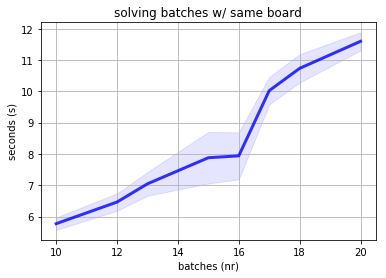

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

x = times
y = np.array(ats)
mean = np.mean(y, axis=0)
std = np.std(y, axis=0)
print(mean, std)

fig, ax = plt.subplots()

ax.plot(x, mean, lw = 3, color='b', alpha = 0.8, label = '')
y_low = mean - std
y_high = mean + std
ax.fill_between(x, y_low, y_high, color='b', alpha = 0.1)

ax.set(xlabel='batches (nr)', ylabel='seconds (s)',
       title='solving batches w/ same board')
ax.grid()

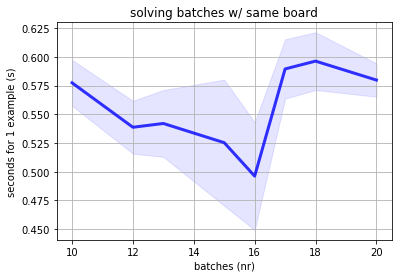

In [37]:
import matplotlib.pyplot as plt

x = times
y = np.array(ats) / x
mean = np.mean(y, axis=0)
std = np.std(y, axis=0)

fig, ax = plt.subplots()

ax.plot(x, mean, lw = 3, color='b', alpha = 0.8, label = '')
y_low = mean - std
y_high = mean + std
ax.fill_between(x, y_low, y_high, color='b', alpha = 0.1)

ax.set(xlabel='batches (nr)', ylabel='seconds for 1 example (s)',
       title='solving batches w/ same board')
ax.grid()

# Card and Range Generator

In [ ]:
# from DataGeneration.random_card_generator import card_generator
# card_generator.generate_cards(6)

In [ ]:
# from DataGeneration.range_generator import RangeGenerator
# r = RangeGenerator()
# board = np.zeros([])
# r.set_board(board)
# BS,CC = 10,6
# ranges = np.zeros([BS,CC])
# r.generate_range(ranges)
# print(np.array2string(ranges, suppress_small=True, precision=2))
# print(np.array2string(np.sum(ranges, axis=1, keepdims=True), suppress_small=True, precision=2))

# Lookahead (test 1)

In [ ]:
# params = TreeParams()
# params.root_node = Node()
# params.root_node.board = card_to_string.string_to_board('Ks')
# params.root_node.street = 2
# params.root_node.current_player = constants.players.P1
# params.root_node.bets = np.array([100, 100])
# params.limit_to_street = False
# tree = tree_builder.build_tree(params)

In [ ]:
# from Tree.tree_strategy_filling import TreeStrategyFilling

# filling = TreeStrategyFilling()

# range1 = card_tools.get_uniform_range(params.root_node.board)
# range2 = card_tools.get_uniform_range(params.root_node.board)

# filling.fill_strategies(tree, P1, range1, range2)
# filling.fill_strategies(tree, P2, range1, range2)

In [ ]:
# starting_ranges = np.zeros([PC,CC], dtype=arguments.dtype)
# starting_ranges[0] = card_tools.get_uniform_range(params.root_node.board)
# starting_ranges[1] = card_tools.get_uniform_range(params.root_node.board)

# tree_values = TreeValues()
# tree_values.compute_values(tree, starting_ranges)

# print('Exploitability: ' + str(tree.exploitability) + ' [chips]' )

# Next Round Value Bucketing test

In [ ]:
# next_round_value = NextRoundValue(None)
# print(next_round_value._range_matrix)
# # test of card to bucket range translation
# range_ = np.arange(1,7).reshape([1,-1]).astype(float)
# next_round_range = np.zeros([1, next_round_value.bucket_count * next_round_value.board_count], dtype=arguments.dtype)
# next_round_value._card_range_to_bucket_range(range_, next_round_range)
# print(next_round_range)

# Next Round Value (mock test)

In [ ]:
# # # test of get_value functionality
# mock_nn = MockNnTerminal()
# # mock_nn = ValueNn()
# next_round_value = NextRoundValue(mock_nn)

# # bets = np.array([100], dtype=float)
# bets = np.array([1200], dtype=float)

# next_round_value.start_computation(bets)

# ranges = np.full([1,2,CC], 1/4, dtype=arguments.dtype)
# values = np.zeros([1,2,CC], dtype=arguments.dtype)

# np.random.seed(0)
# ranges[0][0] = np.array([1,1,0,0,0,0])
# ranges[0][1] = np.array([1,1,1,1,1,1])

# next_round_value.get_value(ranges, values)

# print(values)

# ranges_2 = ranges.reshape([2,CC]).copy()
# values_2 = np.full_like(ranges_2, -1)

# terminal_equity = TerminalEquity()
# terminal_equity.set_board(np.zeros([]))
# terminal_equity.call_value(ranges_2, values_2)
# print('terminal_equity')
# print(values_2)

# # output:
# # [[[ 2.  2.  0.  0. -2. -2.]
# #   [ 0.  0. -1. -1. -1. -1.]]]
# # terminal_equity
# # [[ 0.  0. -1. -1. -1. -1.]
# #  [ 2.  2.  0.  0. -2. -2.]]

In [ ]:
# # needs to comment out some asserts and use_memory = True

# board = card_to_string.string_to_board('Ks')

# values_3 = np.full_like(values, -1)
# next_round_value.get_value_on_board(board, values_3)

# print(values_3)

# # output:
# # [[[ 0.2  0.2  0.   0.8 -0.6 -0.6]
# #   [ 0.   0.   0.   1.  -1.  -1. ]]]

# Nn output

In [ ]:
# data_dir = os.path.join(arguments.data_path, 'tfrecords')
# T = Train(data_dir=data_dir)
# T.train(num_epochs=100, verbose=0)
# model = T.keras_model

In [ ]:
# npy_folder = r'C:\Users\domin\Documents\GitHub\PyStack\Data\TrainSamples\PotBet\npy'
# m = np.load(npy_folder + r'\masks.0.npy')
# x = np.load(npy_folder + r'\inputs.0.npy')
# y = np.load(npy_folder + r'\targets.0.npy')

# y_hat = model.predict(x)

# temp = m[0]
# m = np.zeros([72])
# m[:36] = temp
# m[36:] = temp
# x = x[0]
# y = y[0]
# y_hat = y_hat[0]

# d = np.dot(y_hat, x[:-1])
# d /= 2
# y_new = y_hat - d
# y_new = y_hat

# (y_new*m)[:36] - (y_new*m)[36:]

# Continual Re-solving in Tree

In [ ]:
# board = card_to_string.string_to_board('')

In [ ]:
# params = TreeParams()
# params.root_node = Node()
# params.root_node.board = board
# params.root_node.street = 1
# params.root_node.current_player = constants.players.P1
# params.root_node.bets = np.array([300, 300])
# params.limit_to_street = False
# tree = tree_builder.build_tree(params)

In [ ]:
# filling = TreeStrategyFilling()

# range1 = card_tools.get_uniform_range(board)
# range2 = card_tools.get_uniform_range(board)

# filling.fill_strategies(tree, P1, range1, range2)
# filling.fill_strategies(tree, P2, range1, range2)

In [ ]:
# starting_ranges = np.zeros([PC,CC], dtype=arguments.dtype)
# starting_ranges[0] = card_tools.get_uniform_range(params.root_node.board)
# starting_ranges[1] = card_tools.get_uniform_range(params.root_node.board)

# tree_values = TreeValues()
# tree_values.compute_values(tree, starting_ranges)

# print('Exploitability: ' + str(tree.exploitability) + ' [chips]' )

In [ ]:
# tree_visualizer.draw_tree(tree, size='20,10')

# Range generation

In [ ]:
import numpy as np
def _generate_sorted_range(ranges):
    batch_size = ranges.shape[0]
    mass = np.ones([batch_size], dtype=np.float32)
    _generate_recursion(ranges, mass)

def _generate_recursion(cards, mass):
    batch_size = cards.shape[0]
    assert(mass.shape[0] == batch_size)
    card_count = cards.shape[1]
    # we terminate recursion at size of 1
    if card_count == 1:
        cards[ : , 0 ] = mass.copy()
    else:
        rand = np.random.rand(batch_size)
        mass1 = mass.copy() * rand
        mass2 = mass - mass1
        halfSize = card_count / 2
        # if the tensor contains an odd number of cards,
        # randomize which way the middle card goes
        if halfSize % 1 != 0:
            # if end is .5 then init randomly between two numbers
            halfSize = int(halfSize - 0.5)
            halfSize = halfSize + np.random.randint(2) # (0 or 1)
        halfSize = int(halfSize)

        _generate_recursion(cards[ : , :halfSize ], mass1)
        _generate_recursion(cards[ : , halfSize: ], mass2)

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
def plot(x, x2=None, num_buckets=1000, clip=10, title='', x_name='', x2_name=''):
    bins = np.linspace(0, 1, num_buckets)
    inds = np.digitize(x, bins)
    bucketized_x = bins[ inds ]
    bucketized_x_counts = np.zeros([I, num_buckets])
    for i in range(bucketized_x.shape[1]):
        x_, counts = np.unique(bucketized_x[:,i], return_counts=True)
        bucketized_x_counts[i, :len(counts) ] = counts
#     bucketized_x_counts /= x.shape[0]
    bucketized_x_counts = np.transpose(bucketized_x_counts, [1,0])
    bucketized_x_counts = bucketized_x_counts[ :clip , : ]
    x_axis = bins
    x_axis = x_axis[:clip]
    
    data = []
    
    data.append(go.Surface(
                    z=bucketized_x_counts,
                    y=x_axis,
                    name=x_name
                ))
    
    if x2 is not None:
        inds = np.digitize(x2, bins)
        bucketized_x = bins[ inds ]
        bucketized_x_counts = np.zeros([I, num_buckets])
        for i in range(bucketized_x.shape[1]):
            x_, counts = np.unique(bucketized_x[:,i], return_counts=True)
            bucketized_x_counts[i, :len(counts) ] = counts
#         bucketized_x_counts /= x.shape[0]
        bucketized_x_counts = np.transpose(bucketized_x_counts, [1,0])
        bucketized_x_counts = bucketized_x_counts[ :clip , : ]
        data.append(go.Surface(
                    z=bucketized_x_counts,
                    y=x_axis,
                    name=x2_name
                ))
    
    layout = go.Layout(
        showlegend=True,
        title=title,
        autosize=False,
        width=500,
        height=500,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        ),
        xaxis=dict(
            tickmode='linear',
            ticks='outside',
            tick0=0,
            dtick=1/num_buckets,
            ticklen=1,
#             tickcolor='#000'
        )
    )
    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename='elevations-3d-surface')

In [ ]:
# x = np.random.rand(batch_size,I)
# x = x / np.sum(x, axis=1).reshape([batch_size,1])
# plot(x, num_buckets=num_buckets, clip=clip)

In [ ]:
# I = 100
# batch_size = 1000
# ranges = np.zeros([batch_size,I])
# _generate_sorted_range(ranges)
# ranges
# x = ranges[ : , 0 ]
# y = np.arange(len(x))
# scatterplot(x,y)

In [ ]:
# x = np.random.rand(batch_size,I)
# x = x / np.sum(x, axis=1).reshape([batch_size,1])
# x = x[ : , 2 ]
# scatterplot(x,y)

In [ ]:
def scatterplot(x, y):
    trace = go.Scatter(
        x = x,
        y = y,
        mode = 'markers'
    )

    data = [trace]

    return py.iplot(data, filename='basic-scatter')

In [ ]:
def to_buckets2d(x, num_buckets, clip):
    bins = np.linspace(0, 1, num_buckets)
    inds = np.digitize(x, bins)
    bucketized_x = bins[ inds ]
    bucketized_x_counts = np.zeros([I, num_buckets])
    for i in range(bucketized_x.shape[1]):
        x_, counts = np.unique(bucketized_x[:,i], return_counts=True)
        bucketized_x_counts[i, :len(counts) ] = counts
    bucketized_x_counts /= batch_size
    bucketized_x_counts = np.mean(bucketized_x_counts, axis=0)
    bucketized_x_counts = bucketized_x_counts[ :clip ]
    bins = bins[ :clip ]
    return bucketized_x_counts, bins

In [ ]:
def plot2d(x1, x2, bins, x1_name='', x2_name=''):
    trace1 = go.Scatter(
        x = bins,
        y = x1,
        mode = 'lines',
        name = x1_name
    )
    trace2 = go.Scatter(
        x = bins,
        y = x2,
        mode = 'lines',
        name = x2_name
    )

    data = [trace1, trace2]
    return py.iplot(data, filename='scatter-mode')

In [ ]:
# I = 1300
# batch_size = 10000
# clip = 1000
# num_buckets = 10000
# ranges = np.zeros([batch_size,I])
# _generate_sorted_range(ranges)
# x = np.random.rand(batch_size,I)
# x = x / np.sum(x, axis=1).reshape([batch_size,1])
# x1, bins = to_buckets2d(x, num_buckets, clip)
# x2, bins = to_buckets2d(ranges, num_buckets, clip)
# plot2d(x1, x2, bins, x1_name='Random', x2_name='Recursive')

In [ ]:

# ranges = np.zeros([batch_size,I])
# _generate_sorted_range(ranges)
# x = np.random.rand(batch_size,I)
# x = x / np.sum(x, axis=1).reshape([batch_size,1])
# plot(x, x2=ranges, num_buckets=num_buckets, clip=clip, x2_name='Recursive', x_name='Random')

In [ ]:
# bucketized_x_counts = np.zeros([I, num_buckets])
# for i in range(bucketized_x.shape[1]):
#     x_, counts = np.unique(bucketized_x[:,i], return_counts=True)
#     bucketized_x_counts[i, :len(counts) ] = counts
# bucketized_x_counts /= el
# bucketized_x_counts = np.transpose(bucketized_x_counts, [1,0])

In [ ]:
# x_axis = bins

In [ ]:
# clip = 10
# bucketized_x_counts = bucketized_x_counts[ :clip , : ]
# x_axis = x_axis[:clip]

In [ ]:
# print(bucketized_x_counts.shape)
# print(x_axis.shape)